In [1]:
pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 10.9 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=8b8ce1da62c250c7038d607365abf2c31dce81043bf62ae213324e20421a5dbe
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import sklearn
import keras
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
import os
import shap
import pickle
from keras.models import Model

In [3]:
# Dividir el dataset en entrenamiento y test
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
# Normalizar los valores de los pixeles a valores entre 0 y 1
x_train_mnist, x_test_mnist = x_train_mnist / 255.0, x_test_mnist / 255.0

In [5]:
def plot_images(images, labels, indices, title, color='bone'):
    # Calcula el número de imágenes
    n_images = len(indices)

    # Determina las filas y columnas basadas en la cantidad de imágenes
    rows = int(np.sqrt(n_images))
    cols = n_images // rows if n_images % rows == 0 else n_images // rows + 1

    # Configura la figura
    fig = plt.figure(figsize=(cols*2, rows*2))
    fig.suptitle(title, fontsize=16)
    # Itera sobre el número de índices y muestra las imágenes correspondientes
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f"Label: {labels[idx]}")
        ax.imshow(images[idx], cmap="bone")
        ax.axis('off')
    plt.show()

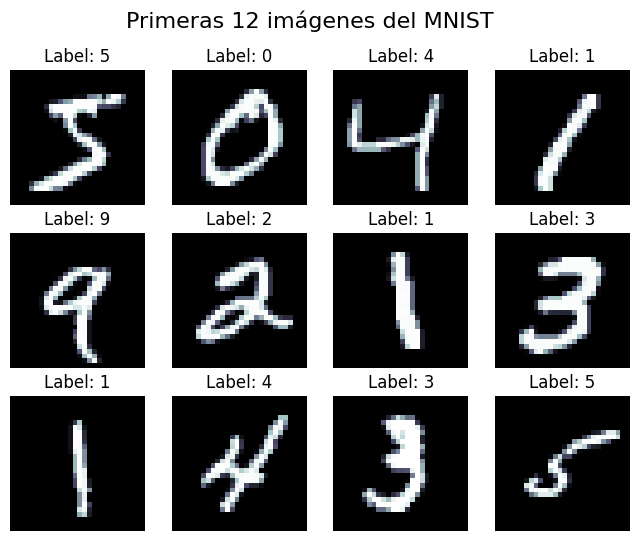

In [6]:
cant = 12
indices = list(range(0, cant, 1))
plot_images(x_train_mnist,y_train_mnist, indices,"Primeras " +str(cant)+ " imágenes del Dataset MNIST")

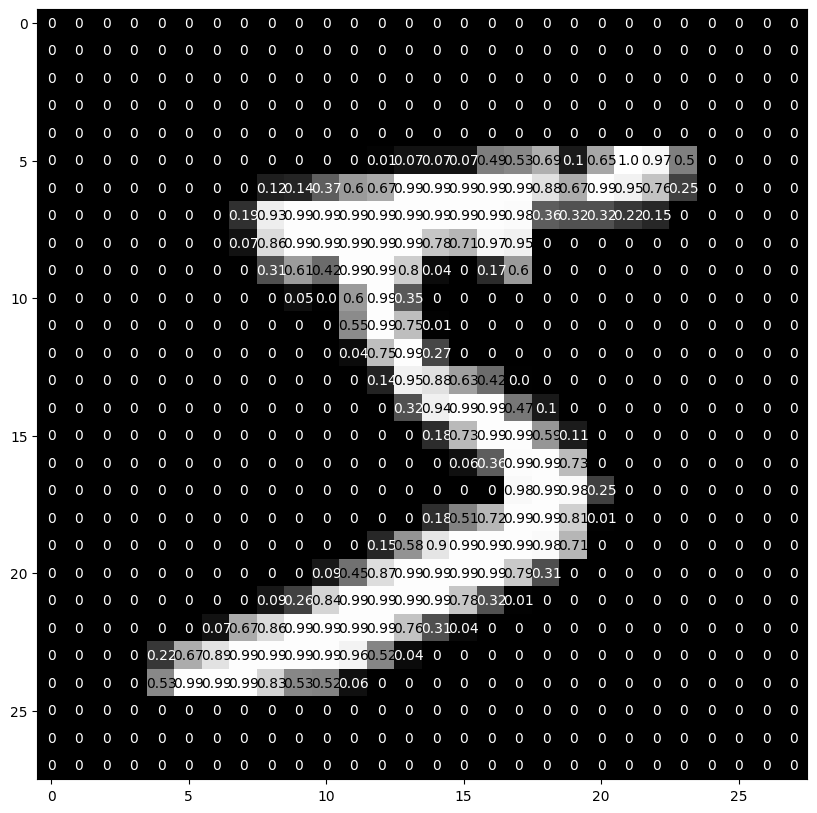

In [7]:
img = np.squeeze(x_train_mnist[0])

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

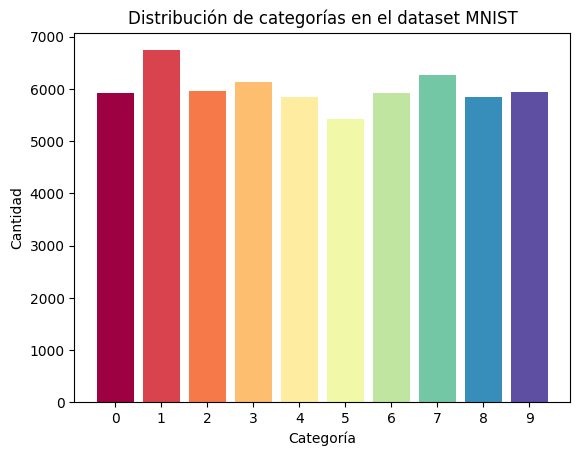

In [8]:
def plot_category_distribution(labels, title, category_names=None):
    # Calcula la cantidad de cada categoría
    unique, counts = np.unique(labels, return_counts=True)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique)))
    # Configura la figura
    fig, ax = plt.subplots()
    ax.bar(unique, counts, color=colors)
    ax.set_xticks(unique)
    if category_names:
        ax.set_xticklabels([category_names[i] for i in unique], rotation=45)
    else:
        ax.set_xticklabels(unique)
    ax.set_title(title)
    ax.set_xlabel('Categoría')
    ax.set_ylabel('Cantidad')
    plt.show()

# Ejemplo de uso con el dataset MNIST
plot_category_distribution(y_train_mnist, 'Distribución de categorías en el dataset MNIST')


In [9]:
labels, counts = np.unique(y_train_mnist, return_counts=True)

In [10]:
labels, counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [11]:
pd.DataFrame({'digitos':labels, 'cantidad':counts, 'porcentaje':counts/sum(counts)*100})

,digitos,cantidad,porcentaje
0,0,5923,9.871667
1,1,6742,11.236667
2,2,5958,9.930000
3,3,6131,10.218333
4,4,5842,9.736667
5,5,5421,9.035000
6,6,5918,9.863333
7,7,6265,10.441667
8,8,5851,9.751667
9,9,5949,9.915000


# Modelo de Clasificación





In [12]:
resultados = pd.DataFrame(columns=['Modelo', 'Descripcion', 'Accuracy'])
predicciones = {}

In [24]:
def evaluate_model(model, X_test, y_test, model_name, dataset_name = "MNIST", viz = True):
    """
    Función para evaluar un modelo y visualizar la matriz de confusión.
    Args:
    - model: modelo entrenado
    - X_test: datos de prueba (features)
    - y_test: etiquetas reales de los datos de prueba
    - model_name: nombre del modelo (para títulos)
    - dataset_name: nombre del dataset (para títulos)
    """
    # Predicción con el modelo
    predictions = model.predict(X_test)

    if(model_name == "DNN" or  "CNN" in model_name):
        predictions = np.argmax(predictions, axis=1)
    if(viz):
        # Generar el reporte de clasificación
        report = classification_report(y_test, predictions, digits = 4)
        print(f"Reporte de Clasificación para el Modelo: {model_name} sobre el DataSet: {dataset_name}:\n{report}")

        # Crear y visualizar la matriz de confusión
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(7, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"Matriz de Confusión para el Modelo: {model_name} sobre el DataSet: {dataset_name}")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()

    acc = accuracy_score(y_test, predictions)
    # Crear un DataFrame con los resultados de esta ejecución
    resultados_nuevos = pd.DataFrame({'Modelo': [model_name],'Descripcion': [model], 'Accuracy': [acc]})

    # Guardar los resultados en el DataFrame global
    global resultados

    resultados = pd.concat([resultados, resultados_nuevos], ignore_index=True)

    return predictions

## CNN

### Preparación de los datos

In [14]:
x_train_mnist_cnn = x_train_mnist.reshape((-1, 28, 28, 1))
x_test_mnist_cnn = x_test_mnist.reshape((-1, 28, 28, 1))

In [15]:
# One-hot encoding de las etiquetas
y_train_mnist = to_categorical(y_train_mnist, 10)
y_test_mnist = to_categorical(y_test_mnist, 10)

### Función de creación de arquitecturas

In [16]:
def create_cnn_model(num_conv_layers=2, num_filters=[32, 64], kernel_size=(3, 3), use_pooling=True, dense_units=[128], dropout_rate=0.5, input_shape=(28, 28, 1), num_classes=10):
    """
    Función para crear una arquitectura CNN en base a los parámetros especificados.
    Args:
    - num_conv_layers: Número de capas convolucionales.
    - num_filters: Lista con el número de filtros para cada capa convolucional.
    - kernel_size: Tamaño del kernel para las capas convolucionales.
    - use_pooling: Si se debe usar MaxPooling después de cada capa convolucional.
    - dense_units: Lista con el número de unidades para cada capa densa.
    - dropout_rate: Tasa de dropout.
    - input_shape: Forma de la entrada.
    - num_classes: Número de clases (salida de la red).

    Returns:
    - model: El modelo de Keras.
    """

    model = Sequential()

    # Añadir capas convolucionales
    for i in range(num_conv_layers):
        if i == 0:
            model.add(Conv2D(num_filters[i], kernel_size=kernel_size, activation='relu', input_shape=input_shape))
        else:
            model.add(Conv2D(num_filters[i], kernel_size=kernel_size, activation='relu'))

        if use_pooling:
            model.add(MaxPooling2D(pool_size=(2, 2)))

    # Aplanar la salida de las capas convolucionales
    model.add(Flatten())

    # Añadir capas densas
    for units in dense_units:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Añadir la capa de salida
    model.add(Dense(num_classes, activation='softmax'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


### Gráficas del Modelo

In [17]:
def graficar_comportamiento(model_history, name_model = None):
    if name_model != None:
        print("Comportamientos para ", name_model)
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title("Model Accuracy - Precisión de entrenamiento y validación")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title("Model Loss - Pérdida de entrenamiento y validación")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()

### Creación y Evaluación de modelos

#### Modelo 1

Este modelo elemental es ideal para empezar a entender cómo funciona una CNN. Con una única capa convolucional y una capa densa, es fácil de entrenar y proporciona una base sólida para mejoras posteriores.

In [18]:
model_1 = create_cnn_model(
    num_conv_layers=1,
    num_filters=[32],
    kernel_size=(3, 3),
    use_pooling=True,
    dense_units=[128],
    dropout_rate=0.5,
    input_shape=(28, 28, 1),
    num_classes=10
)
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [19]:
model_1.fit(x_train_mnist, y_train_mnist, epochs=10, batch_size=200, validation_split=0.1)


Epoch 1/10
270/270 [==============================] - 28s 98ms/step - loss: 0.3880 - accuracy: 0.8837 - val_loss: 0.0952 - val_accuracy: 0.9752
Epoch 2/10
270/270 [==============================] - 30s 109ms/step - loss: 0.1350 - accuracy: 0.9605 - val_loss: 0.0586 - val_accuracy: 0.9838
Epoch 3/10
270/270 [==============================] - 42s 154ms/step - loss: 0.0938 - accuracy: 0.9726 - val_loss: 0.0541 - val_accuracy: 0.9842
Epoch 4/10
270/270 [==============================] - 25s 94ms/step - loss: 0.0772 - accuracy: 0.9774 - val_loss: 0.0459 - val_accuracy: 0.9880
Epoch 5/10
270/270 [==============================] - 24s 90ms/step - loss: 0.0638 - accuracy: 0.9806 - val_loss: 0.0464 - val_accuracy: 0.9875
Epoch 6/10
270/270 [==============================] - 25s 94ms/step - loss: 0.0549 - accuracy: 0.9834 - val_loss: 0.0423 - val_accuracy: 0.9883
Epoch 7/10
270/270 [==============================] - 26s 97ms/step - loss: 0.0479 - accuracy: 0.9852 - val_loss: 0.0398 - val_accurac

Comportamientos para  model_1


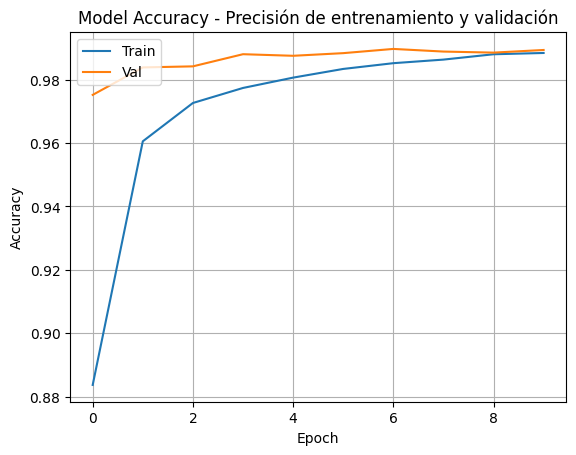

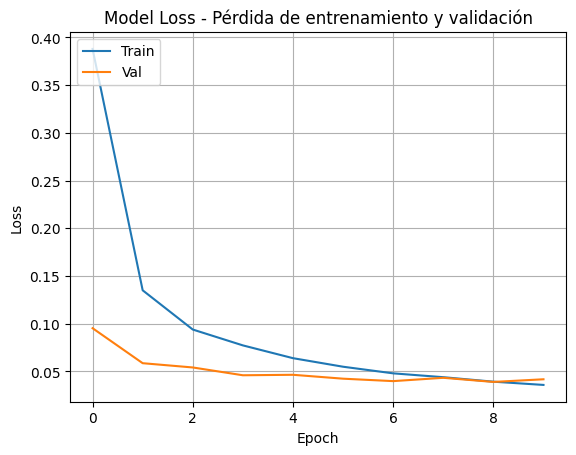

In [20]:
graficar_comportamiento(model_1.history, "model_1")

In [ ]:
model_1.save('model_1.keras')

313/313 [==============================] - 3s 11ms/step
Reporte de Clasificación para el Modelo: CNN Simple sobre el DataSet: MNIST:
              precision    recall  f1-score   support

           0     0.9879    0.9959    0.9919       980
           1     0.9903    0.9938    0.9921      1135
           2     0.9902    0.9835    0.9869      1032
           3     0.9843    0.9921    0.9882      1010
           4     0.9878    0.9878    0.9878       982
           5     0.9887    0.9843    0.9865       892
           6     0.9906    0.9885    0.9896       958
           7     0.9845    0.9903    0.9874      1028
           8     0.9836    0.9867    0.9851       974
           9     0.9899    0.9742    0.9820      1009

    accuracy                         0.9878     10000
   macro avg     0.9878    0.9877    0.9877     10000
weighted avg     0.9878    0.9878    0.9878     10000



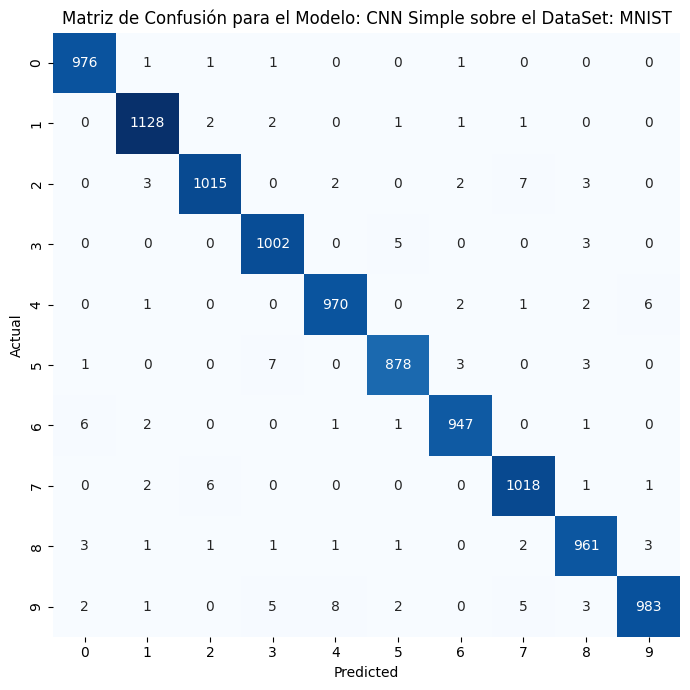

In [25]:
predicciones['model_1'] = evaluate_model(model_1, x_test_mnist, np.argmax(y_test_mnist, axis=1), "CNN Simple")

#### Modelo 2
Se añade una segunda capa convolucional y se aumenta el número de filtros.

Este modelo es un paso adelante del elemental, con dos capas convolucionales para capturar características más complejas y mejorar la precisión. Ideal para datasets de tamaño moderado.

In [46]:
model_2 = create_cnn_model(
    num_conv_layers=2,
    num_filters=[32, 64],
    kernel_size=(3, 3),
    use_pooling=True,
    dense_units=[128],
    dropout_rate=0.5,
    input_shape=(28, 28, 1),
    num_classes=10
)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

Epoch 1/10
270/270 [==============================] - 46s 167ms/step - loss: 0.3764 - accuracy: 0.8850 - val_loss: 0.0720 - val_accuracy: 0.9787
Epoch 2/10
270/270 [==============================] - 41s 153ms/step - loss: 0.1158 - accuracy: 0.9652 - val_loss: 0.0561 - val_accuracy: 0.9830
Epoch 3/10
270/270 [==============================] - 45s 165ms/step - loss: 0.0831 - accuracy: 0.9752 - val_loss: 0.0446 - val_accuracy: 0.9873
Epoch 4/10
270/270 [==============================] - 40s 148ms/step - loss: 0.0690 - accuracy: 0.9794 - val_loss: 0.0384 - val_accuracy: 0.9885
Epoch 5/10
270/270 [==============================] - 41s 152ms/step - loss: 0.0576 - accuracy: 0.9828 - val_loss: 0.0336 - val_accuracy: 0.9910
Epoch 6/10
270/270 [==============================] - 42s 155ms/step - loss: 0.0522 - accuracy: 0.9847 - val_loss: 0.0345 - val_accuracy: 0.9913
Epoch 7/10
270/270 [==============================] - 41s 153ms/step - loss: 0.0455 - accuracy: 0.9861 - val_loss: 0.0381 - val_ac

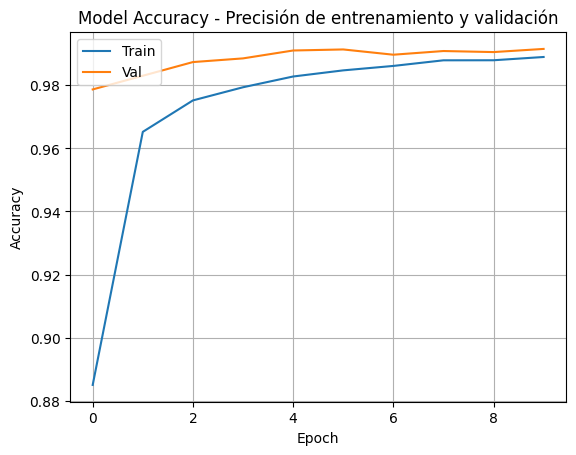

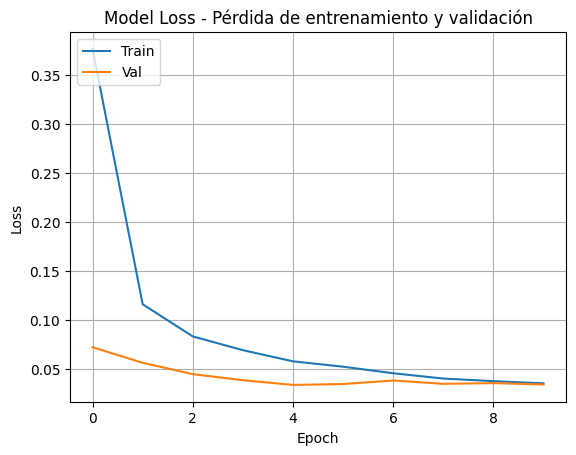

313/313 [==============================] - 4s 12ms/step
Reporte de Clasificación para el Modelo: CNN Intermedia sobre el DataSet: MNIST:
              precision    recall  f1-score   support

           0     0.9919    0.9969    0.9944       980
           1     0.9913    0.9991    0.9952      1135
           2     0.9865    0.9903    0.9884      1032
           3     0.9950    0.9931    0.9941      1010
           4     0.9979    0.9898    0.9939       982
           5     0.9822    0.9899    0.9860       892
           6     0.9968    0.9885    0.9927       958
           7     0.9883    0.9874    0.9878      1028
           8     0.9959    0.9856    0.9907       974
           9     0.9862    0.9901    0.9881      1009

    accuracy                         0.9912     10000
   macro avg     0.9912    0.9911    0.9911     10000
weighted avg     0.9912    0.9912    0.9912     10000



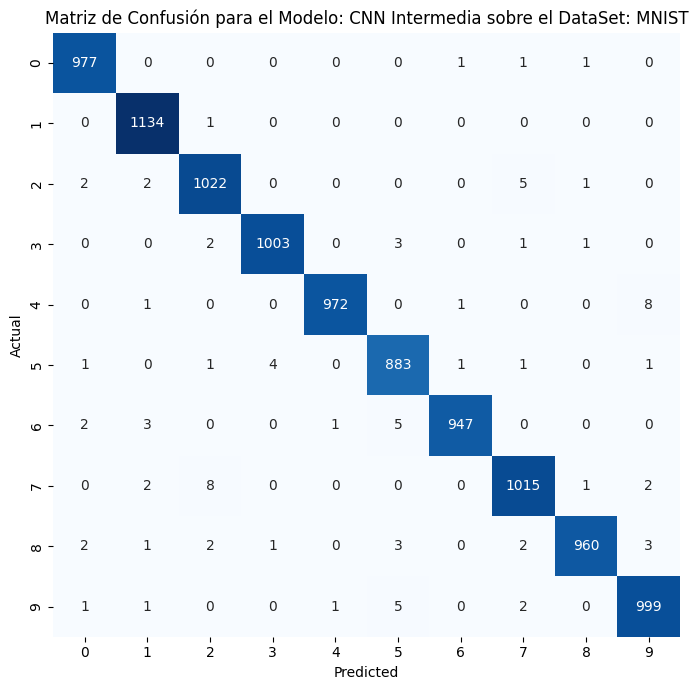

In [51]:
model_2.fit(x_train_mnist, y_train_mnist, epochs=10, batch_size=200, validation_split=0.1)
graficar_comportamiento(model_2.history, "model_2")
predicciones['model_2'] = evaluate_model(model_2, x_test_mnist, np.argmax(y_test_mnist, axis=1), "CNN Intermedia")

#### Modelo 3: Intermedio
Se añade una tercera capa convolucional y se aumenta la capacidad de la red.
Este modelo intermedio cuenta con tres capas convolucionales y dos capas densas, lo que permite capturar características aún más complejas y manejar mejor los datos de mayor tamaño.

In [47]:
model_3 = create_cnn_model(
    num_conv_layers=3,
    num_filters=[32, 64, 128],
    kernel_size=(3, 3),
    use_pooling=True,
    dense_units=[128, 64],
    dropout_rate=0.5,
    input_shape=(28, 28, 1),
    num_classes=10
)
model_3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 128)        

Epoch 1/10
270/270 [==============================] - 47s 170ms/step - loss: 0.7642 - accuracy: 0.7475 - val_loss: 0.1235 - val_accuracy: 0.9643
Epoch 2/10
270/270 [==============================] - 45s 168ms/step - loss: 0.2162 - accuracy: 0.9426 - val_loss: 0.0851 - val_accuracy: 0.9747
Epoch 3/10
270/270 [==============================] - 46s 169ms/step - loss: 0.1506 - accuracy: 0.9601 - val_loss: 0.0602 - val_accuracy: 0.9812
Epoch 4/10
270/270 [==============================] - 45s 167ms/step - loss: 0.1231 - accuracy: 0.9676 - val_loss: 0.0510 - val_accuracy: 0.9853
Epoch 5/10
270/270 [==============================] - 45s 168ms/step - loss: 0.0986 - accuracy: 0.9741 - val_loss: 0.0481 - val_accuracy: 0.9855
Epoch 6/10
270/270 [==============================] - 49s 182ms/step - loss: 0.0914 - accuracy: 0.9768 - val_loss: 0.0470 - val_accuracy: 0.9877
Epoch 7/10
270/270 [==============================] - 45s 167ms/step - loss: 0.0733 - accuracy: 0.9816 - val_loss: 0.0483 - val_ac

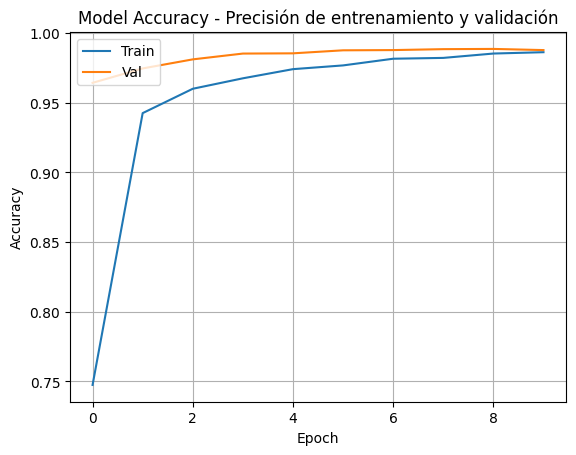

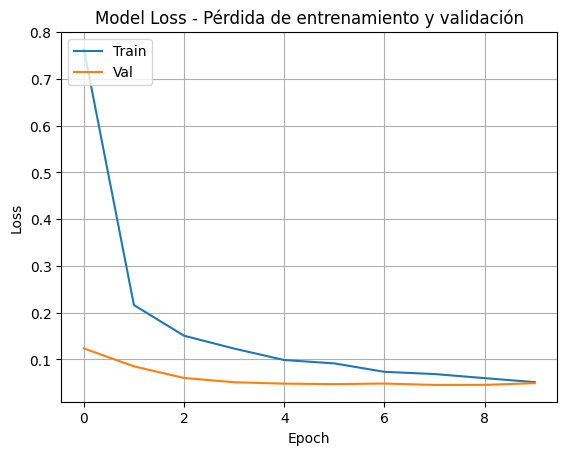

313/313 [==============================] - 3s 9ms/step
Reporte de Clasificación para el Modelo: CNN Avanzada sobre el DataSet: MNIST:
              precision    recall  f1-score   support

           0     0.9949    0.9898    0.9923       980
           1     0.9956    0.9947    0.9952      1135
           2     0.9788    0.9835    0.9812      1032
           3     0.9940    0.9822    0.9880      1010
           4     0.9908    0.9888    0.9898       982
           5     0.9822    0.9899    0.9860       892
           6     0.9896    0.9916    0.9906       958
           7     0.9758    0.9796    0.9777      1028
           8     0.9857    0.9918    0.9887       974
           9     0.9891    0.9851    0.9871      1009

    accuracy                         0.9877     10000
   macro avg     0.9876    0.9877    0.9877     10000
weighted avg     0.9877    0.9877    0.9877     10000



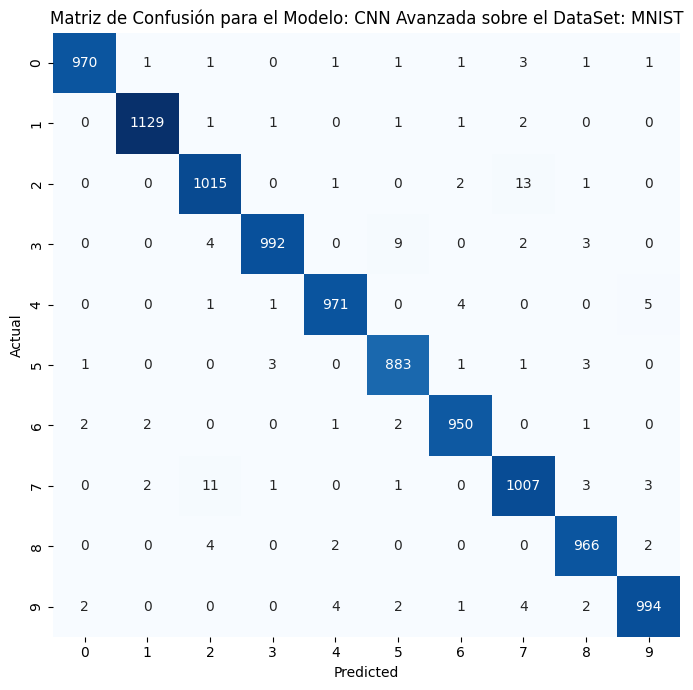

In [52]:
model_3.fit(x_train_mnist, y_train_mnist, epochs=10, batch_size=200, validation_split=0.1)
graficar_comportamiento(model_3.history, "model_3")
predicciones['model_3'] = evaluate_model(model_3, x_test_mnist, np.argmax(y_test_mnist, axis=1), "CNN Avanzada")

# Explicabilidad

### Lime

In [54]:
import lime
def explain_instance_with_lime(image, classifier_fn, name_model, val_real, model_type='cnn', labels=None, **kwargs):
    explainer = lime.lime_image.LimeImageExplainer()
    val_pred = np.argmax(classifier_fn(image.reshape(1, 28, 28, 1)))
    # Convertir la imagen a RGB para que sea compatible con LIME
    image_rgb = gray2rgb(image.reshape(28, 28))

    # Adaptar la imagen para la predicción dependiendo del tipo de modelo
    def model_predict(data):
        if model_type == 'flat':
            x_flat = data[:, :, :, 0].reshape(-1, 28 * 28)  # Aplanar las imágenes para modelos de scikit-learn
        else:
            x_flat = data[:, :, :, 0].reshape(-1, 28, 28, 1)  # Mantener formato de imagen para CNN

        return classifier_fn(x_flat)

    # Explicar la instancia usando LIME y mostrar la imagen original
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Imagen Original")
    plt.axis('off')

    # Generar una explicación de LIME con solo las características positivas
    explanation = explainer.explain_instance(image_rgb, model_predict, top_labels=5, num_samples=50, **kwargs)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='viridis')
    plt.title("Características Positivas")
    plt.axis('off')

    # Generar una explicación de LIME con todas las características
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='viridis')
    plt.title("Todas las Características")
    plt.axis('off')

    # Agregar el título de la explicación de LIME
    if labels is None:
        plt.suptitle(f"Explicación de LIME para el Modelo: {name_model} - El modelo dice {val_pred} y es {val_real}")
    else:
        plt.suptitle(f"Explicación de LIME para el Modelo: {name_model} - El modelo dice {labels[val_pred]} y es {labels[val_real]}")
    plt.show()

    # Seleccionar la misma clase explicada en las figuras anteriores
    ind = explanation.top_labels[0]

    # Mapear cada peso de explicación al superpíxel correspondiente
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

    # Mostrar el mapa de calor. La visualización tiene más sentido si se usa una barra de color simétrica.
    plt.figure(figsize=(4, 4))
    plt.imshow(heatmap, cmap='coolwarm', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()
    plt.title("Mapa de Calor de la Explicación")
    plt.axis('off')
    plt.show()

### Shap

In [68]:
# Función para mostrar los errores más importantes
def display_errors(model, most_important_errors, test_errors, test_labels_classes_errors, test_true_errors, test_labels_errors):
    for idx in most_important_errors:
        i = idx  # Índice del error más importante
        # Calcular los valores SHAP
        background = x_train_mnist[np.random.choice(x_train_mnist.shape[0], 100, replace=False)].reshape(-1, 28, 28, 1)
        explainer = shap.DeepExplainer(model, background)
        shap_values = explainer.shap_values(test_errors[i].reshape(1, 28, 28, 1))

        # Etiquetas y probabilidades
        probabilities = test_labels_errors[i]
        index_names = np.array([f"{x}\n{probabilities[x]:.3%}" for x in range(10)]).reshape(1, 10)

        # Mostrar los resultados
        print(f"Predicted label: {test_labels_classes_errors[i]}\nTrue label: {test_true_errors[i]}")

        fig, axes = plt.subplots(1, 11, figsize=(24, 5))  # Añadir un subplot adicional para la imagen original

        # Mostrar la imagen original
        axes[0].imshow(test_errors[i].reshape(28, 28), cmap='gray')
        axes[0].set_title("Original")
        axes[0].axis('off')

        # Mostrar las imágenes con valores SHAP superpuestos
        for digit in range(10):
            # Limitar los valores SHAP para mejorar la visualización
            shap_img = shap_values[0][..., digit].reshape(28, 28)
            max_val = np.abs(shap_img).max()
            img = axes[digit + 1].imshow(shap_img, cmap='coolwarm', vmin=-max_val, vmax=max_val, alpha=0.7)
            axes[digit + 1].imshow(test_errors[i].reshape(28, 28), cmap='gray', alpha=0.3)
            axes[digit + 1].set_title(f"Digito {digit}\n{probabilities[digit]:.3%}")
            axes[digit + 1].axis('off')

        plt.tight_layout()

        # Añadir barra de colores completa
        cbar = fig.colorbar(img, ax=axes, orientation='horizontal', fraction=0.03, pad=0.1, aspect=150)
        cbar.set_label('SHAP value')

        plt.show()


In [34]:
import shap
import numpy as np
import matplotlib.pyplot as plt

def explain_instance_with_shap(image, model, name_model, val_pred, val_real, labels=None):
    # Preparar el explicador SHAP
    background = x_train_mnist[np.random.choice(x_train_mnist.shape[0], 100, replace=False)].reshape(-1, 28, 28, 1)
    explainer = shap.DeepExplainer(model, background)

    # Obtener valores SHAP para la imagen seleccionada
    shap_values = explainer.shap_values(image.reshape(1, 28, 28, 1))

    # Visualizar la explicación SHAP
    plt.figure(figsize=(10, 10))
    shap.image_plot(shap_values, image.reshape(1, 28, 28, 1))

    # Obtener probabilidades de predicción del modelo
    probabilities = model.predict(image.reshape(1, 28, 28, 1))[0]

    # Visualizar probabilidades
    plt.figure(figsize=(10, 4))
    plt.bar(range(10), probabilities)
    plt.xlabel('Clase')
    plt.ylabel('Probabilidad')
    plt.title('Probabilidades de Predicción por Clase')
    plt.xticks(range(10), labels if labels else range(10))

    # Título de la explicación SHAP
    if labels is None:
        plt.suptitle(f"Explicación de SHAP para el Modelo: {name_model} - El modelo dice {val_pred} y es {val_real}")
    else:
        plt.suptitle(f"Explicación de SHAP para el Modelo: {name_model} - El modelo dice {labels[val_pred]} y es {labels[val_real]}")
    plt.show()


#### Ver explicaciones

1/1 [==============================] - 0s 79ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


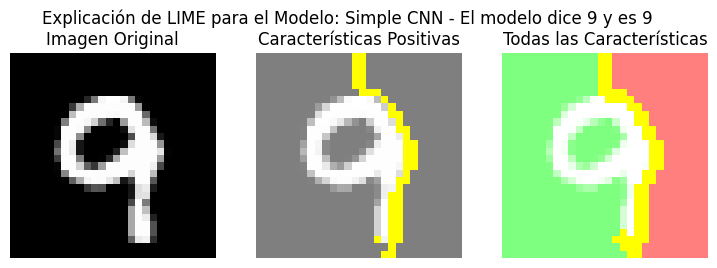

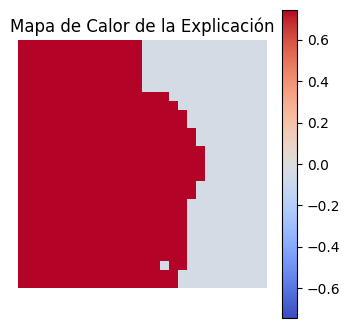

1/1 [==============================] - 0s 144ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


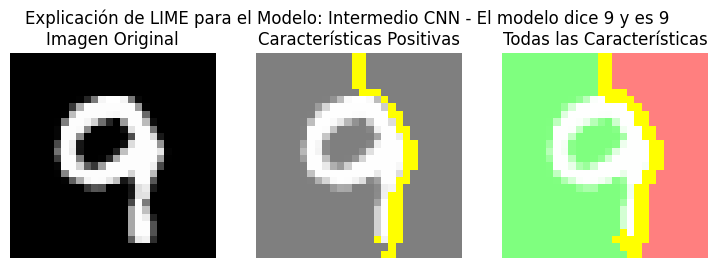

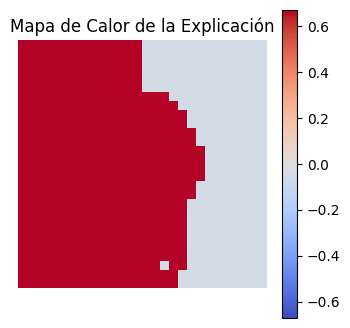

1/1 [==============================] - 0s 165ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


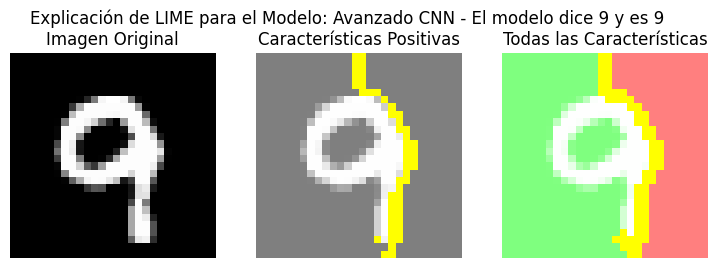

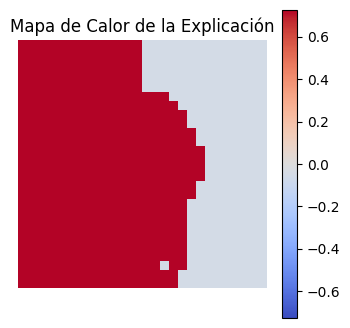

In [56]:
# Seleccionar una imagen del conjunto de prueba
i = 99
image = x_test_mnist[i]
val_real = np.argmax(y_test_mnist[i])

# Explicar la instancia
explain_instance_with_lime(image, model_1.predict, "Simple CNN", val_real, model_type='cnn')
# Explicar la instancia
explain_instance_with_lime(image, model_2.predict, "Intermedio CNN", val_real, model_type='cnn')
# Explicar la instancia
explain_instance_with_lime(image, model_3.predict, "Avanzado CNN", val_real, model_type='cnn')

1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


<Figure size 1000x1000 with 0 Axes>

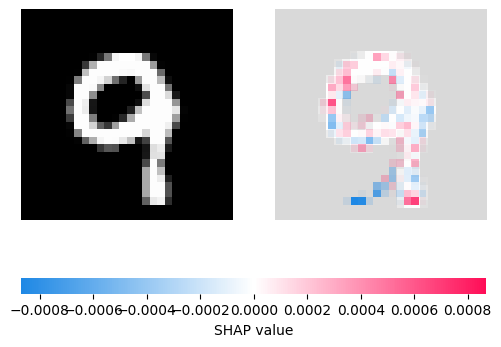

1/1 [==============================] - 0s 33ms/step


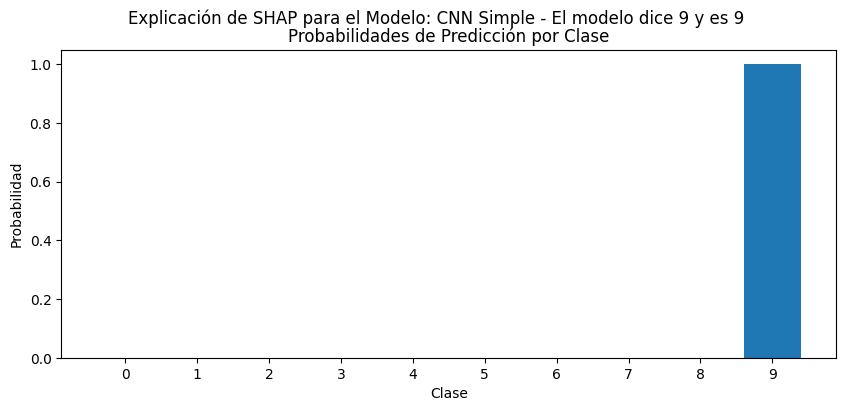

In [37]:
# Seleccionar una imagen del conjunto de prueba
i = 99
image = x_test_mnist[i]
val_pred = np.argmax(model_1.predict(image.reshape(1, 28, 28, 1)))
val_real = np.argmax(y_test_mnist[i])

# Explicar la instancia
explain_instance_with_shap(image, model_1, "CNN Simple", val_pred, val_real)

## Ejemplos Bien y Mal Clasificados


In [62]:
# Predecir en el conjunto de prueba
preds = model_1.predict(x_test_mnist)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_test_mnist, axis=1)

# Identificar los errores de predicción
errors = (pred_labels != true_labels)

test_labels_classes_errors = pred_labels[errors]
test_labels_errors = preds[errors]
test_true_errors = true_labels[errors]
test_errors = x_test_mnist[errors]

# Calcular las probabilidades y deltas
test_labels_errors_prob = np.max(test_labels_errors, axis=1)
true_prob_errors = np.diagonal(np.take(test_labels_errors, test_true_errors, axis=1))
delta_pred_true_errors = test_labels_errors_prob - true_prob_errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_delta_errors[-4:]


313/313 [==============================] - 3s 9ms/step


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Predicted label: 7
True label: 8


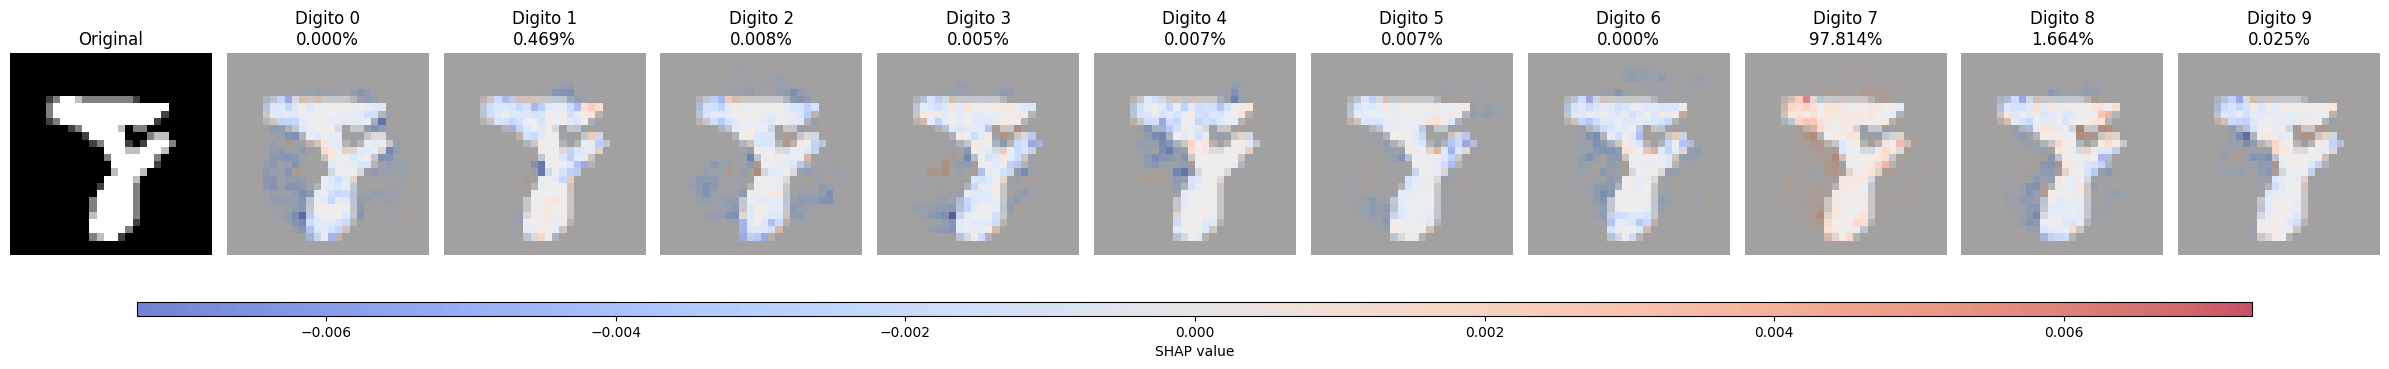

Predicted label: 7
True label: 2


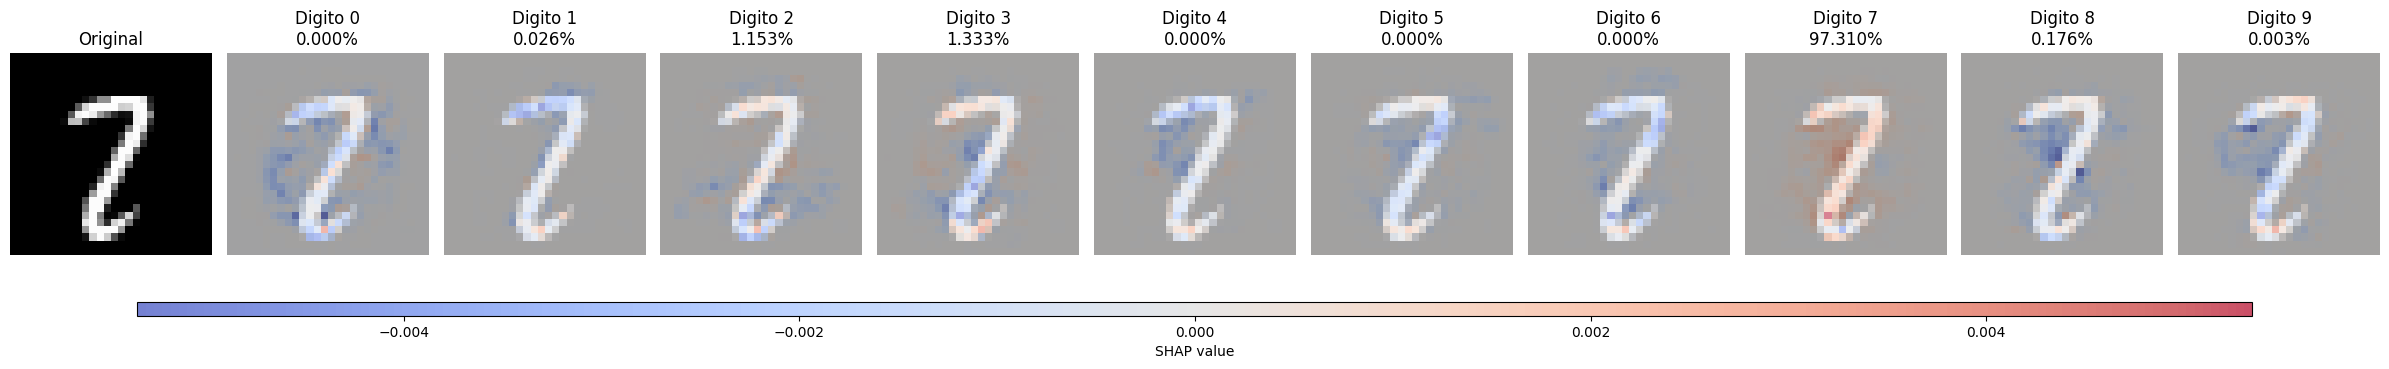

Predicted label: 2
True label: 7


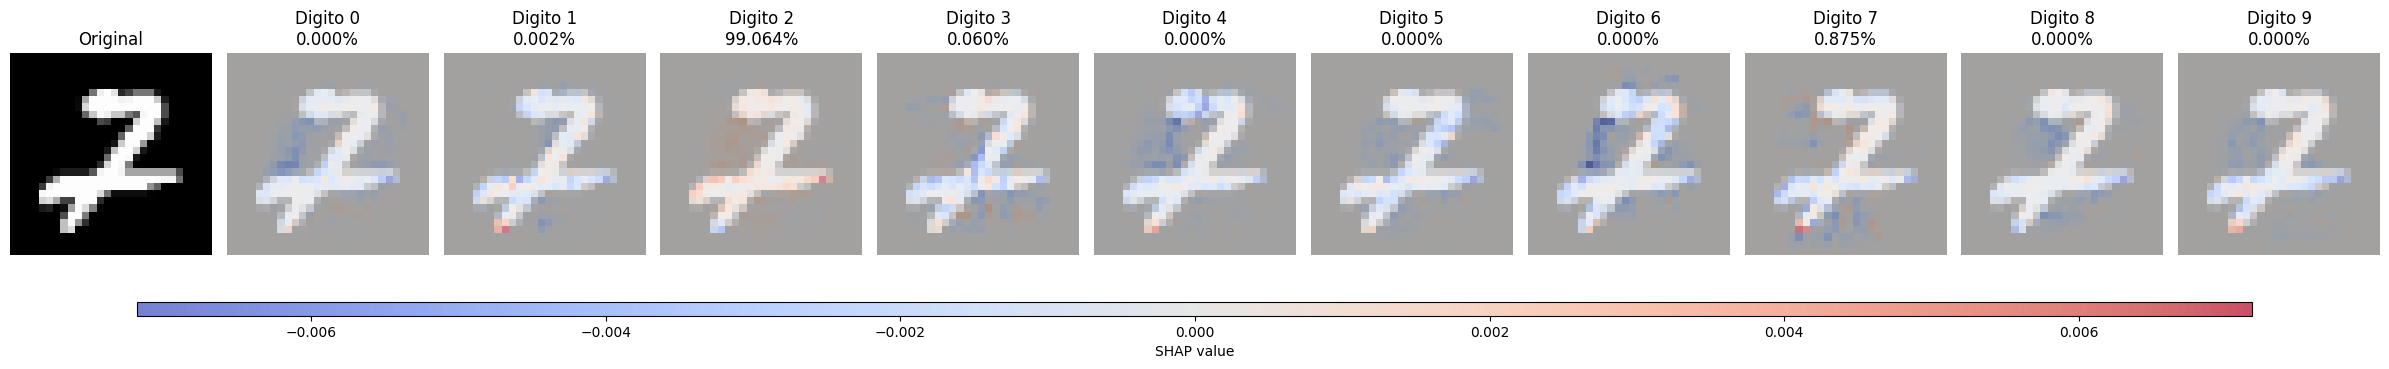

Predicted label: 8
True label: 3


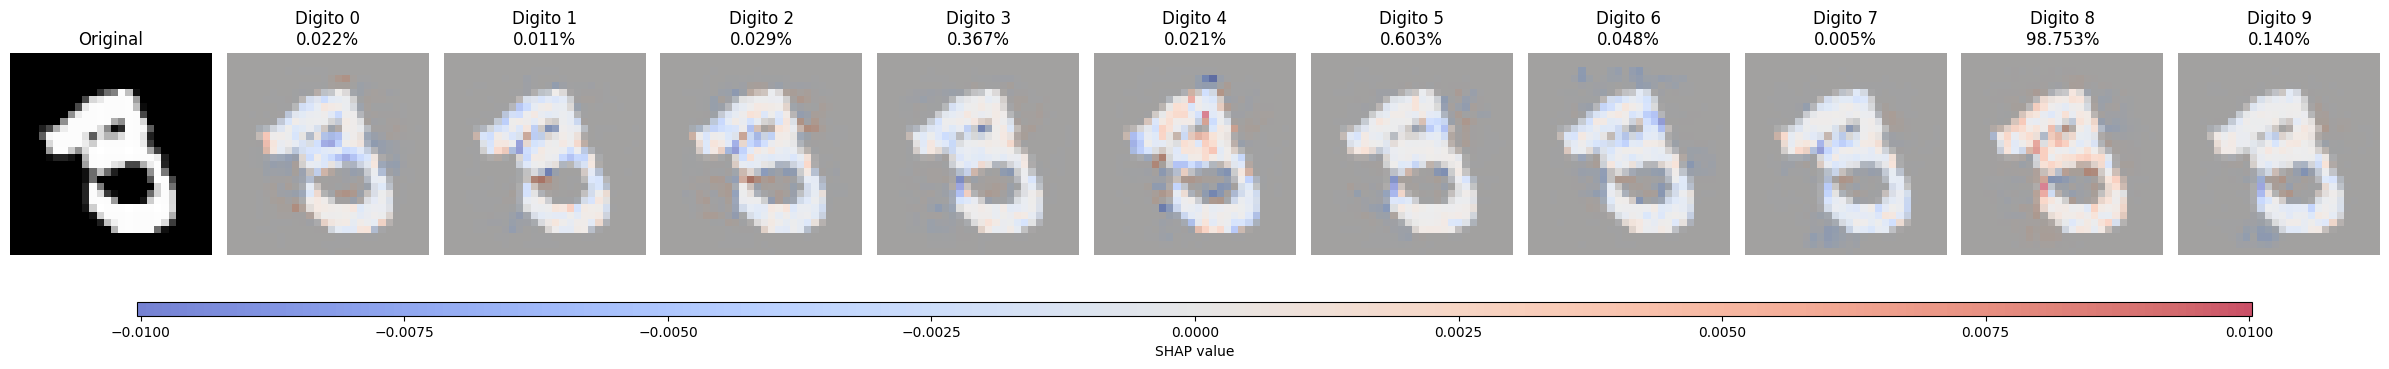

Predicted label: 6
True label: 5


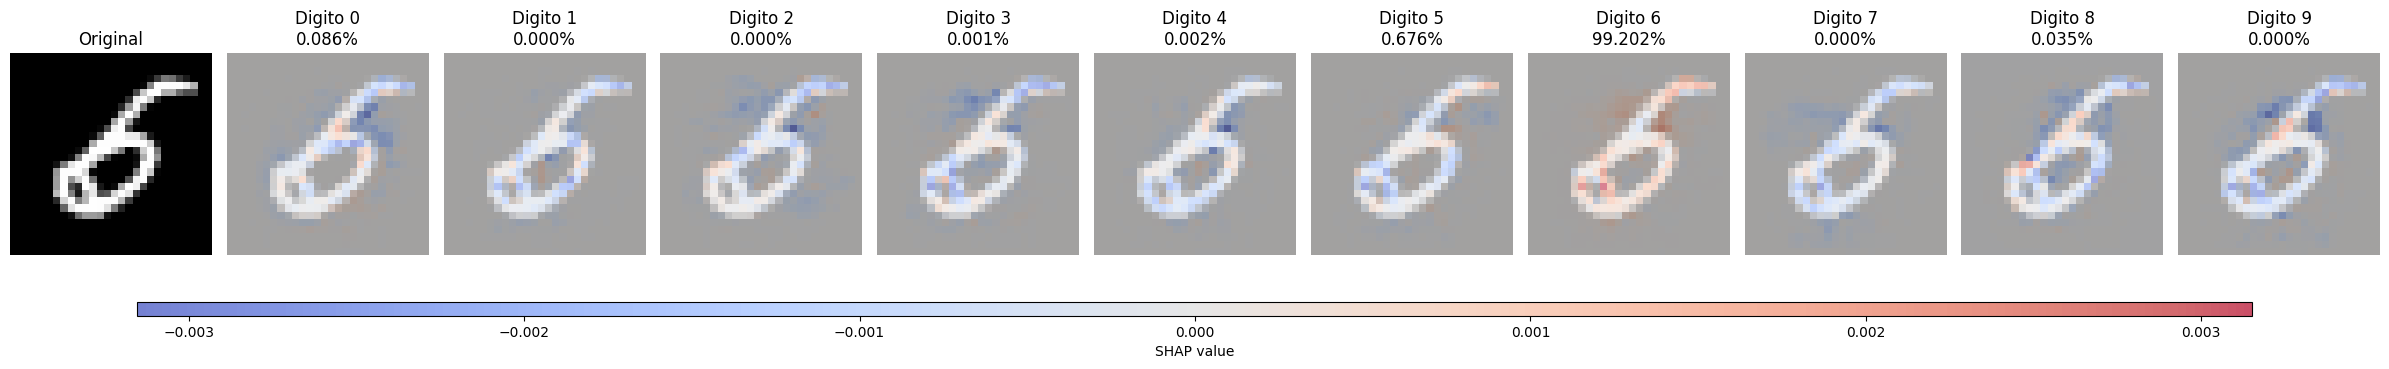

Predicted label: 2
True label: 7


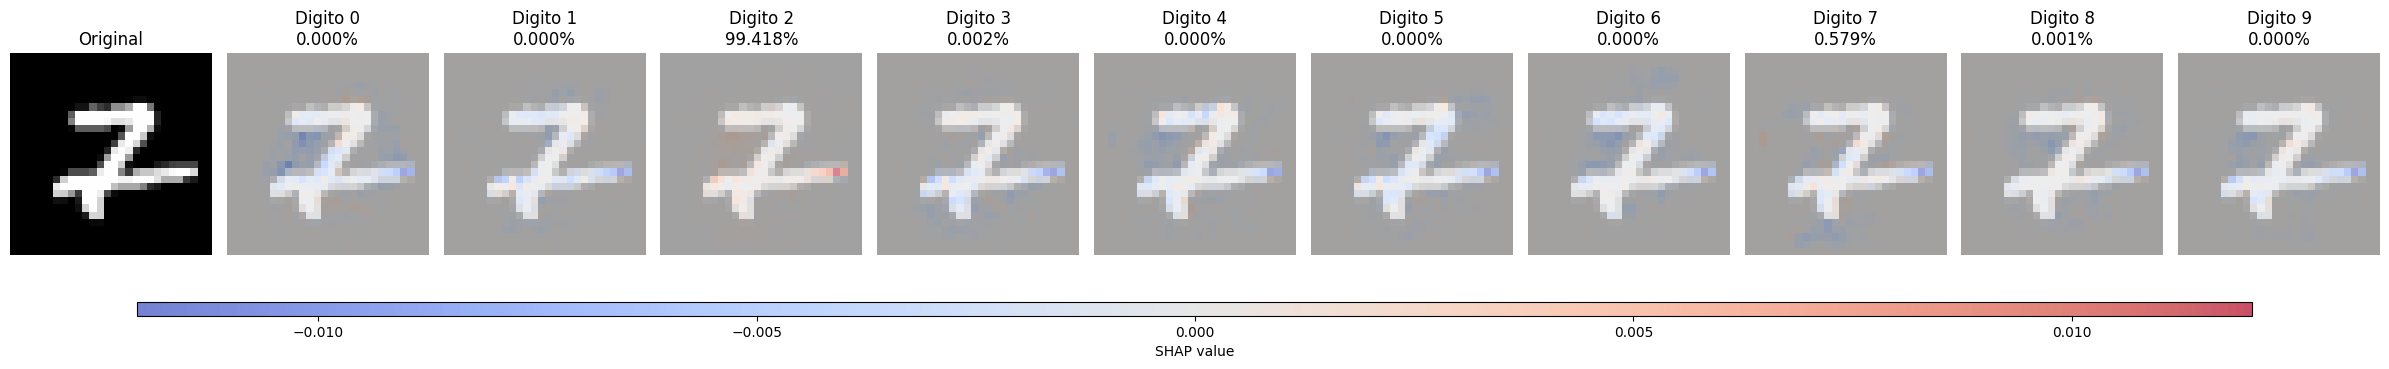

Predicted label: 4
True label: 6


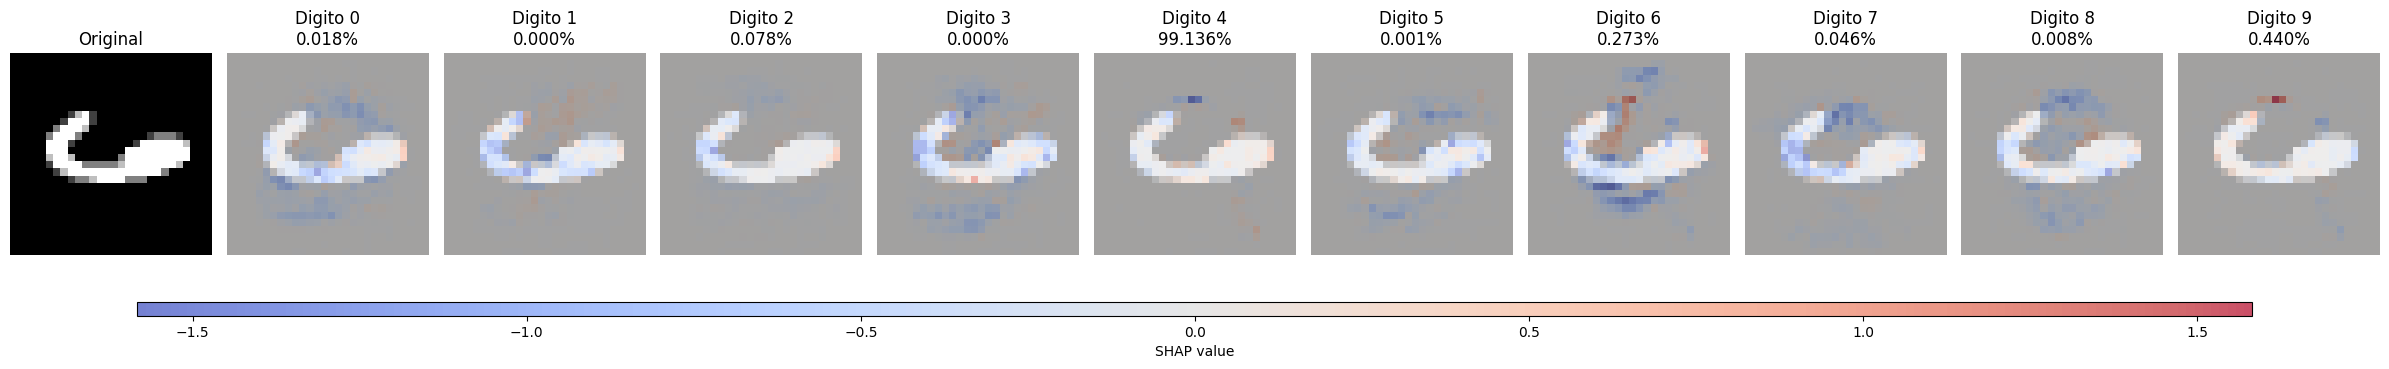

Predicted label: 5
True label: 6


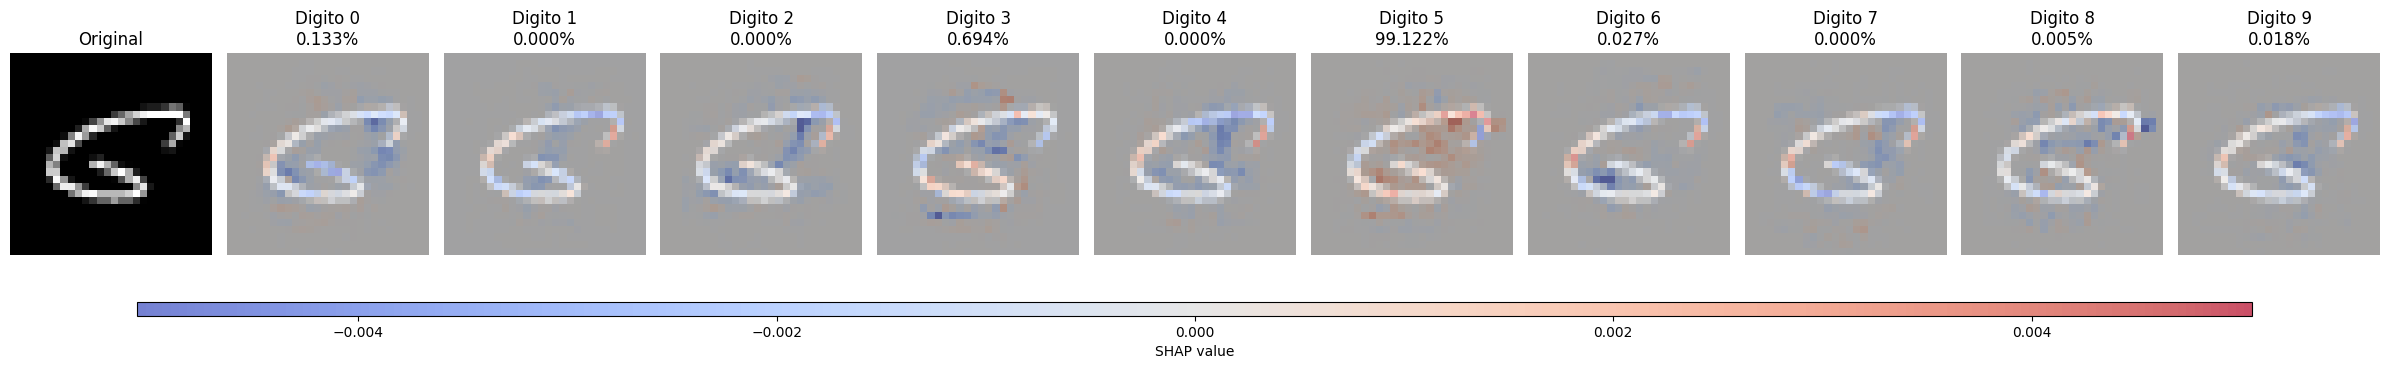

Predicted label: 0
True label: 8


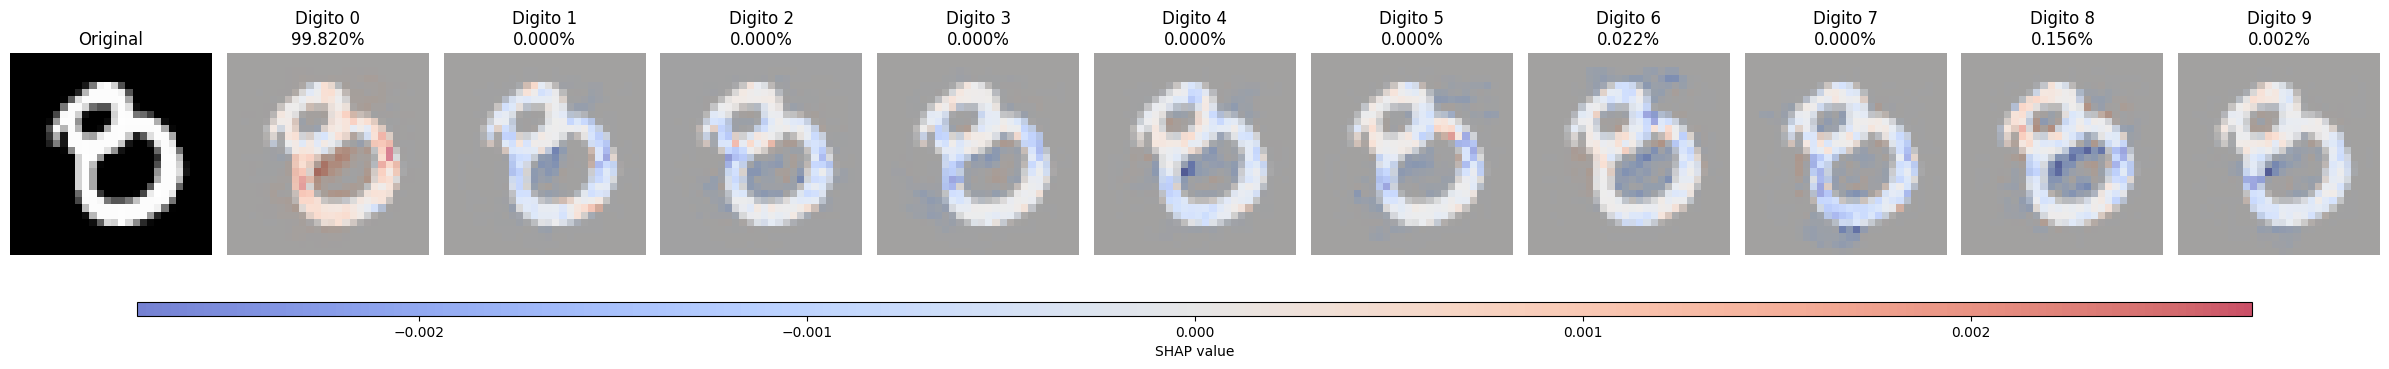

Predicted label: 1
True label: 6


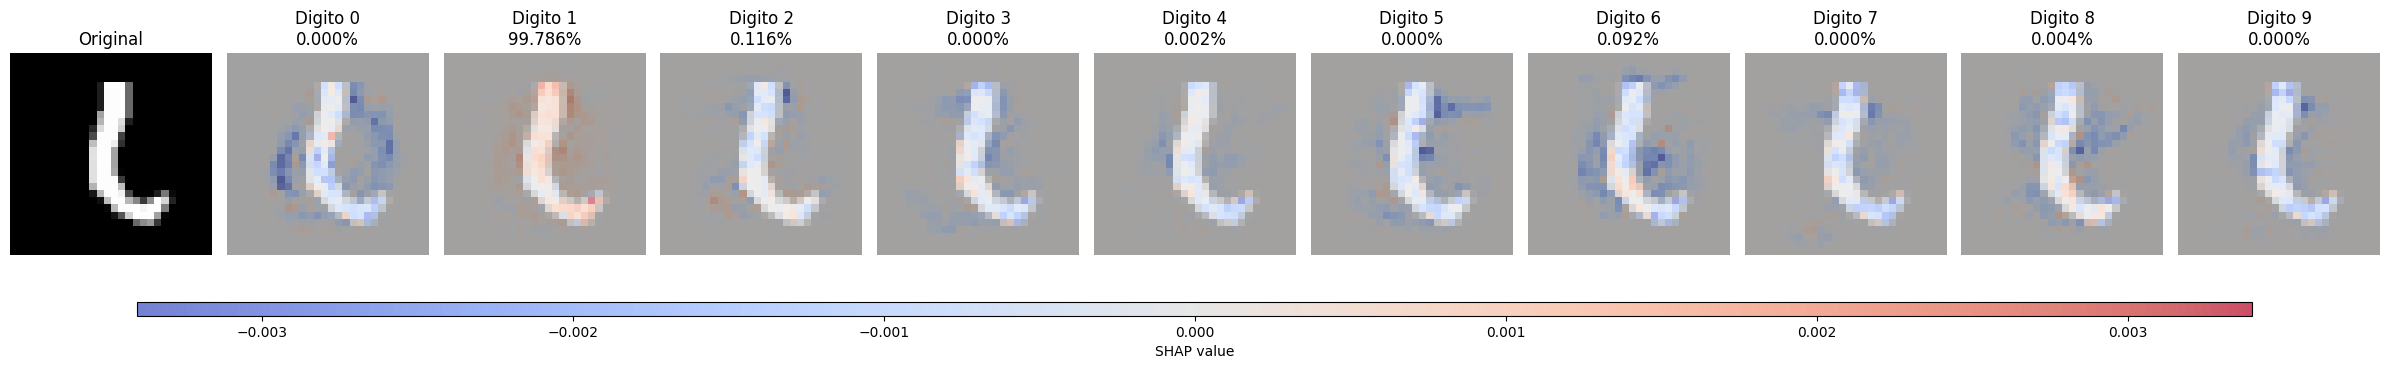

In [59]:
# Mostrar los errores más importantes
display_errors(model_1, most_important_errors, test_errors, test_labels_classes_errors, test_true_errors)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Predicted label: 7
True label: 8


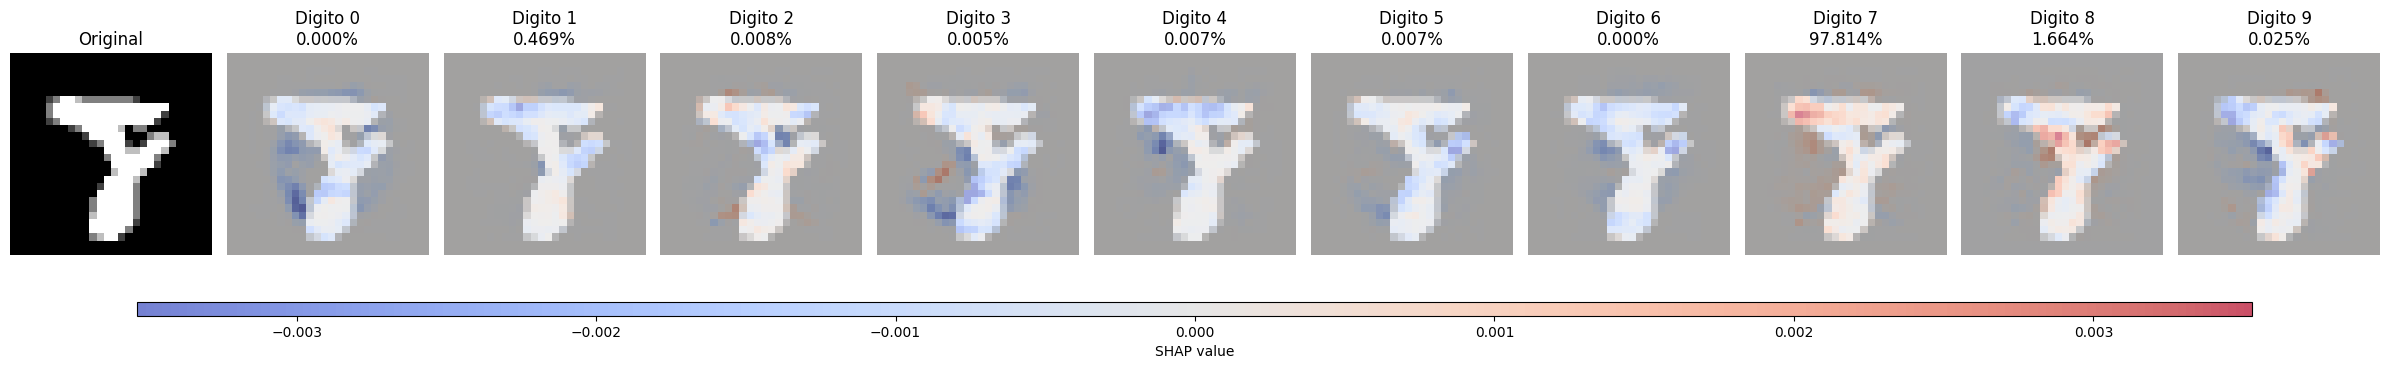

Predicted label: 7
True label: 2


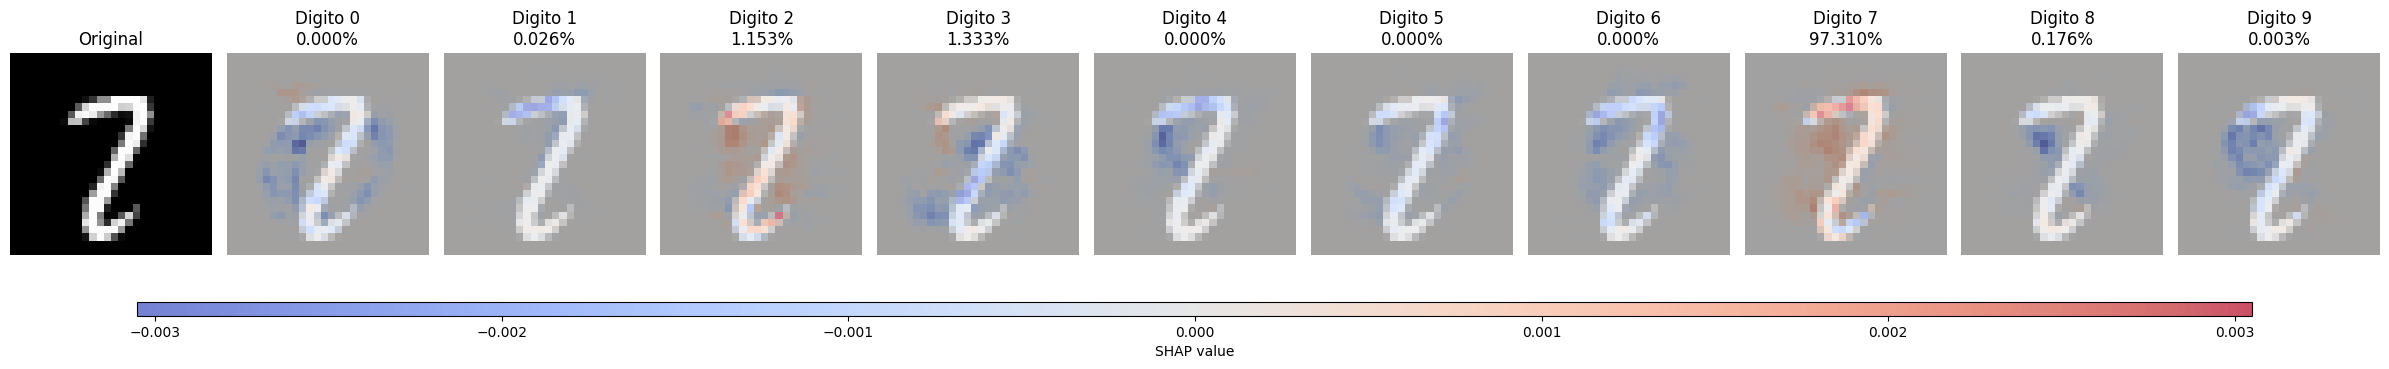

Predicted label: 2
True label: 7


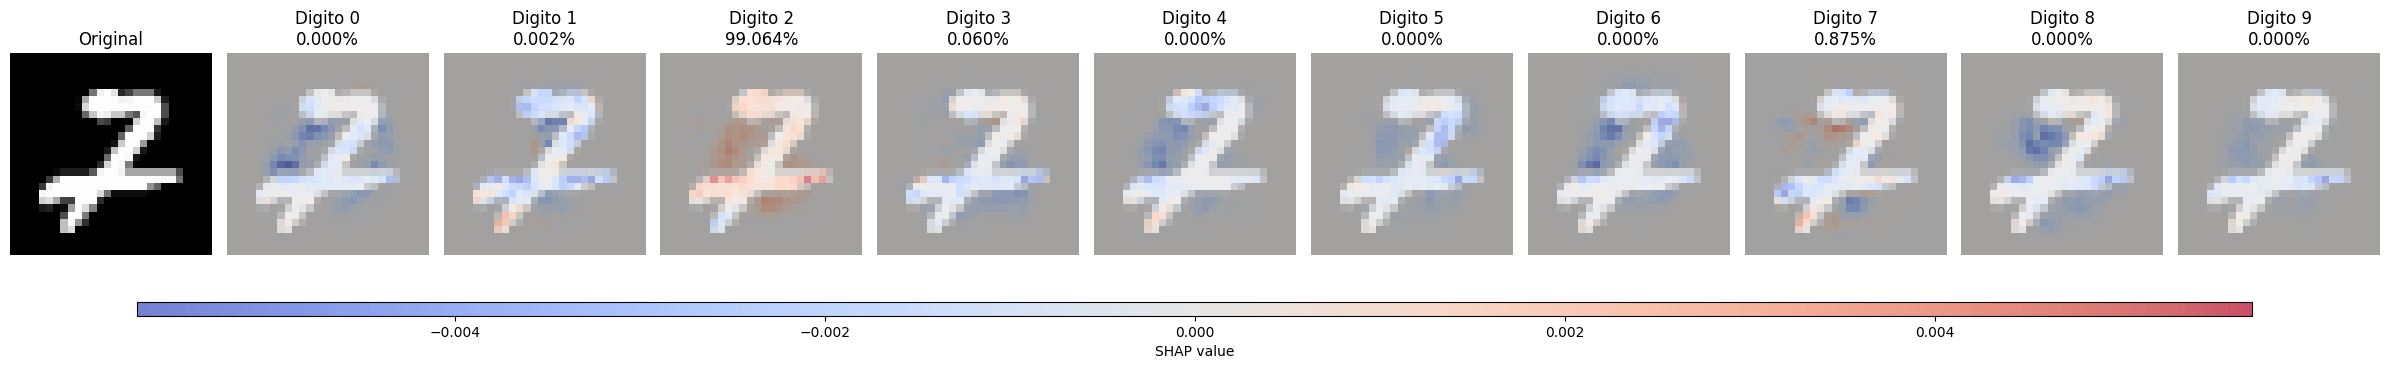

Predicted label: 8
True label: 3


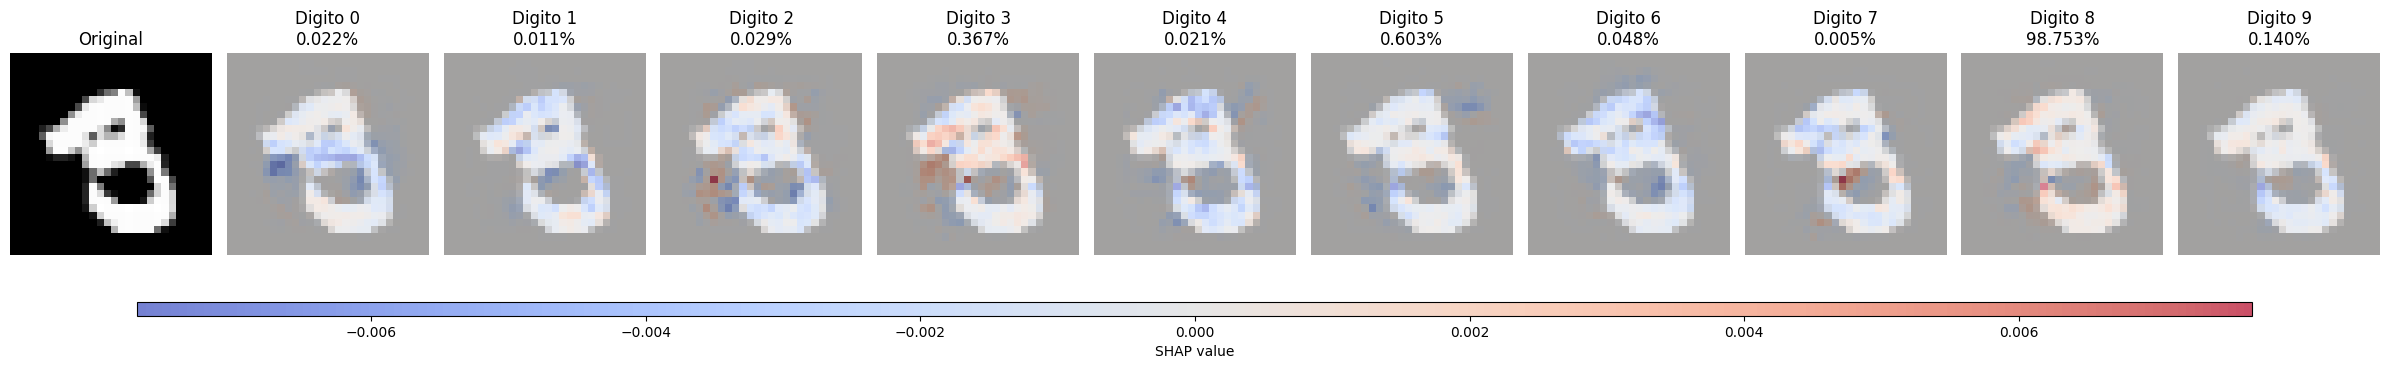

Predicted label: 6
True label: 5


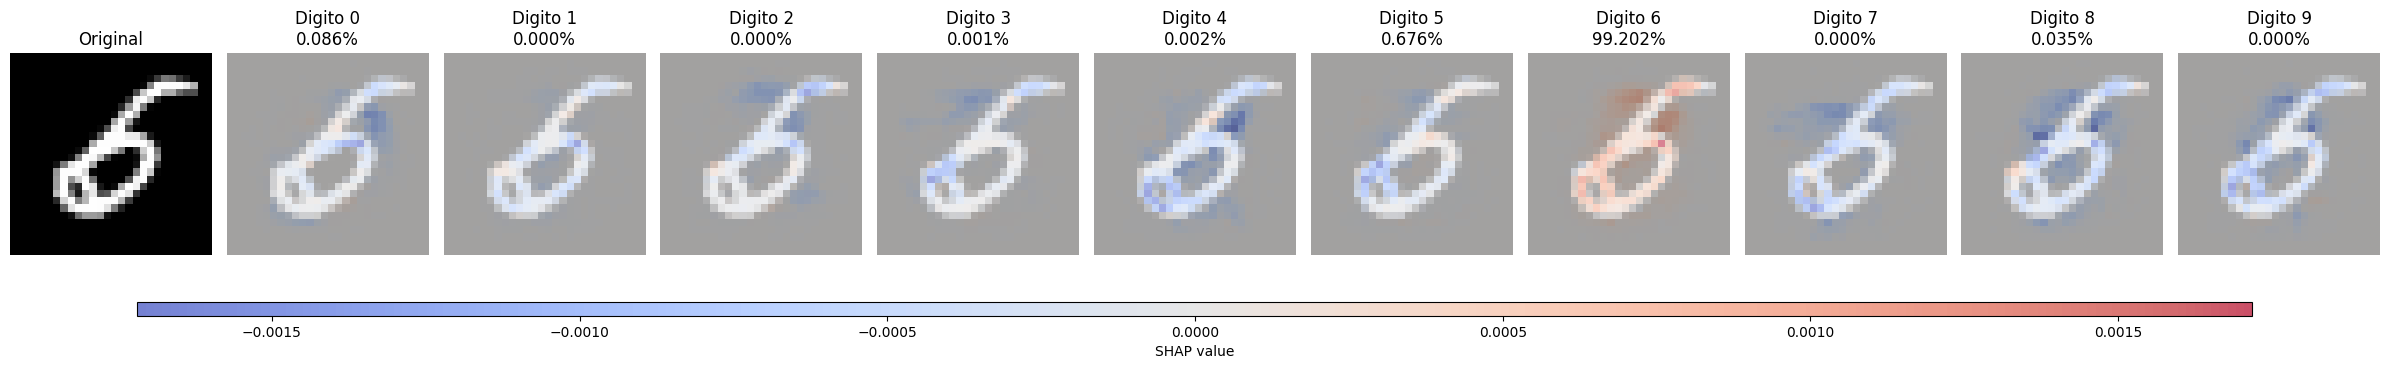

Predicted label: 2
True label: 7


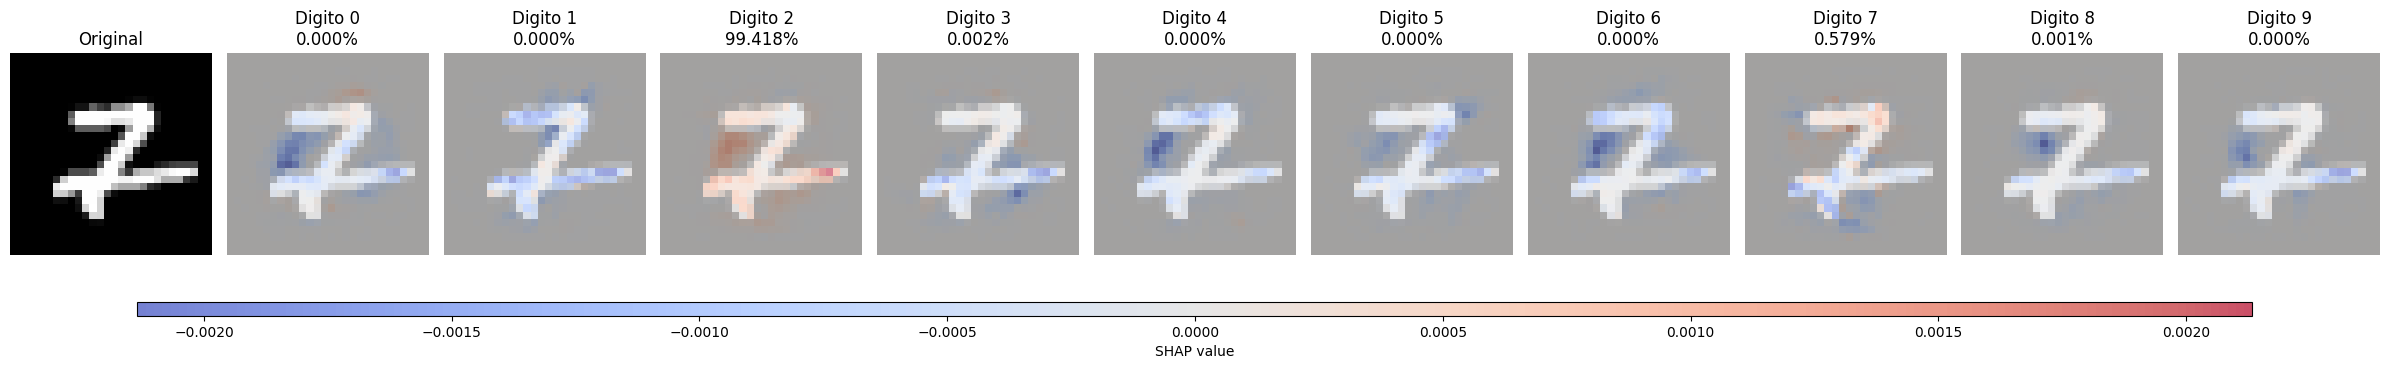

Predicted label: 4
True label: 6


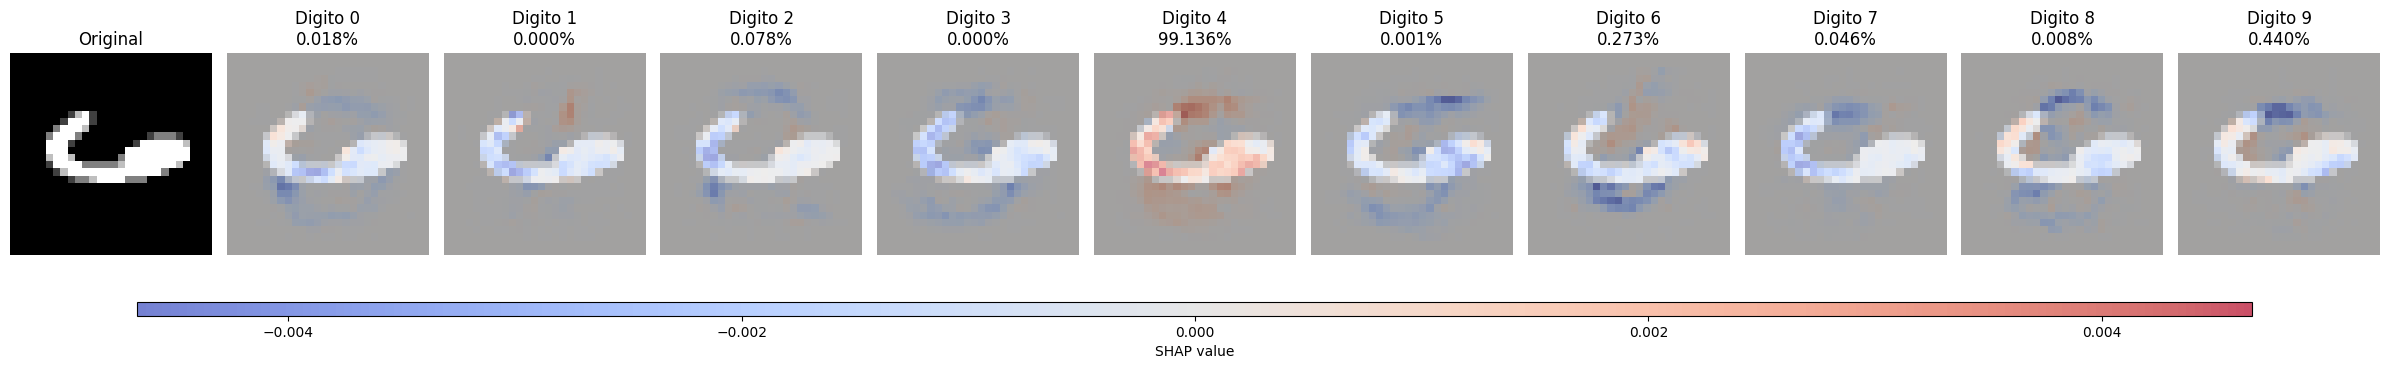

Predicted label: 5
True label: 6


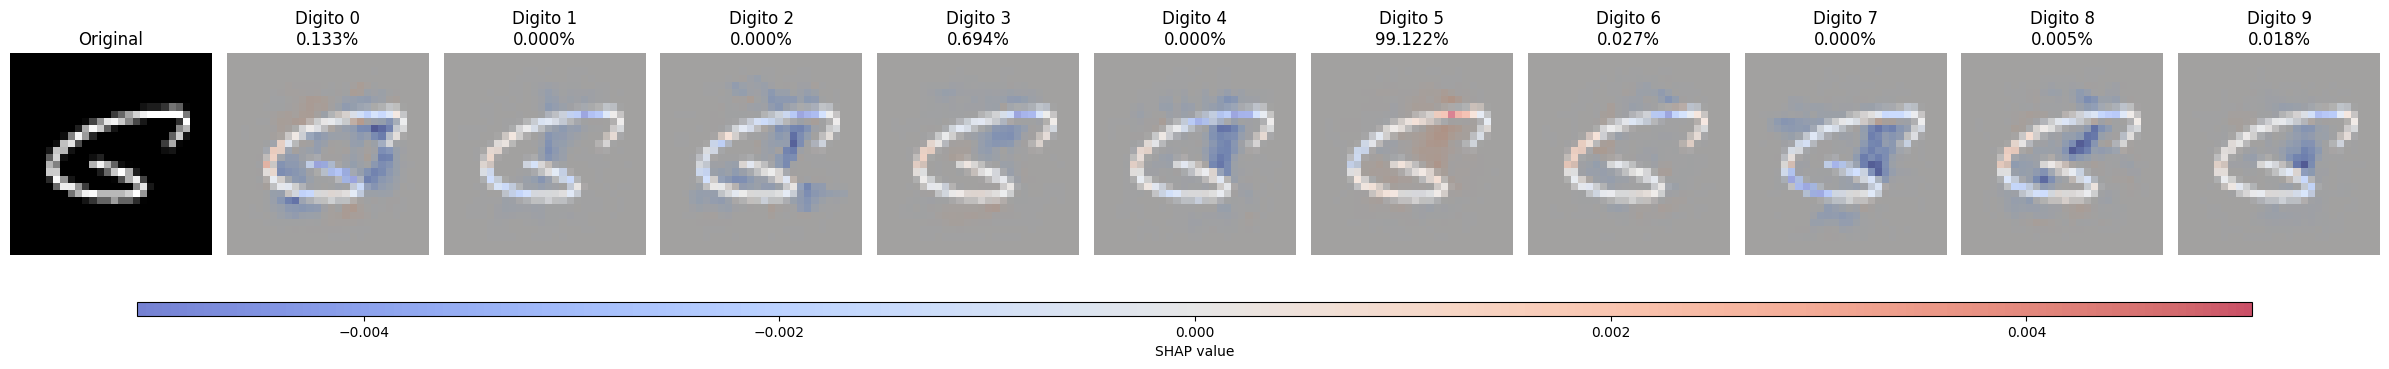

Predicted label: 0
True label: 8


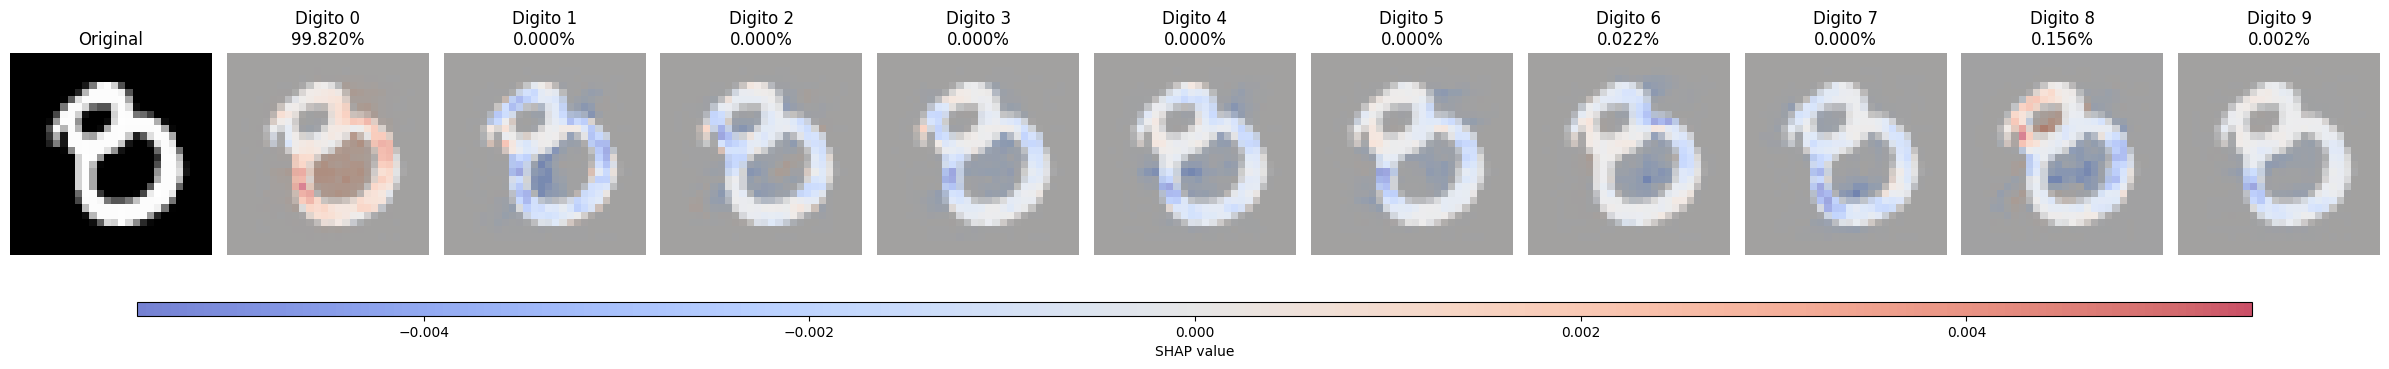

Predicted label: 1
True label: 6


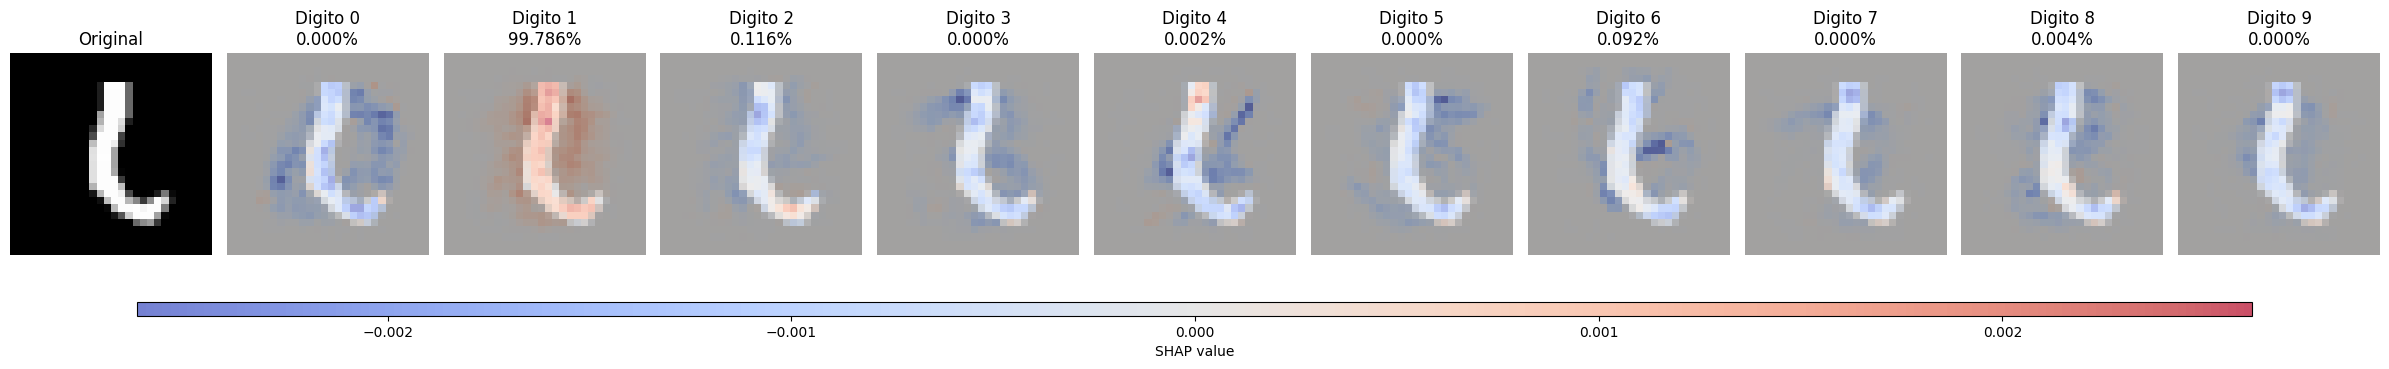

In [60]:
# Mostrar los errores más importantes
display_errors(model_2, most_important_errors, test_errors, test_labels_classes_errors, test_true_errors)

Predicted label: 7
True label: 8


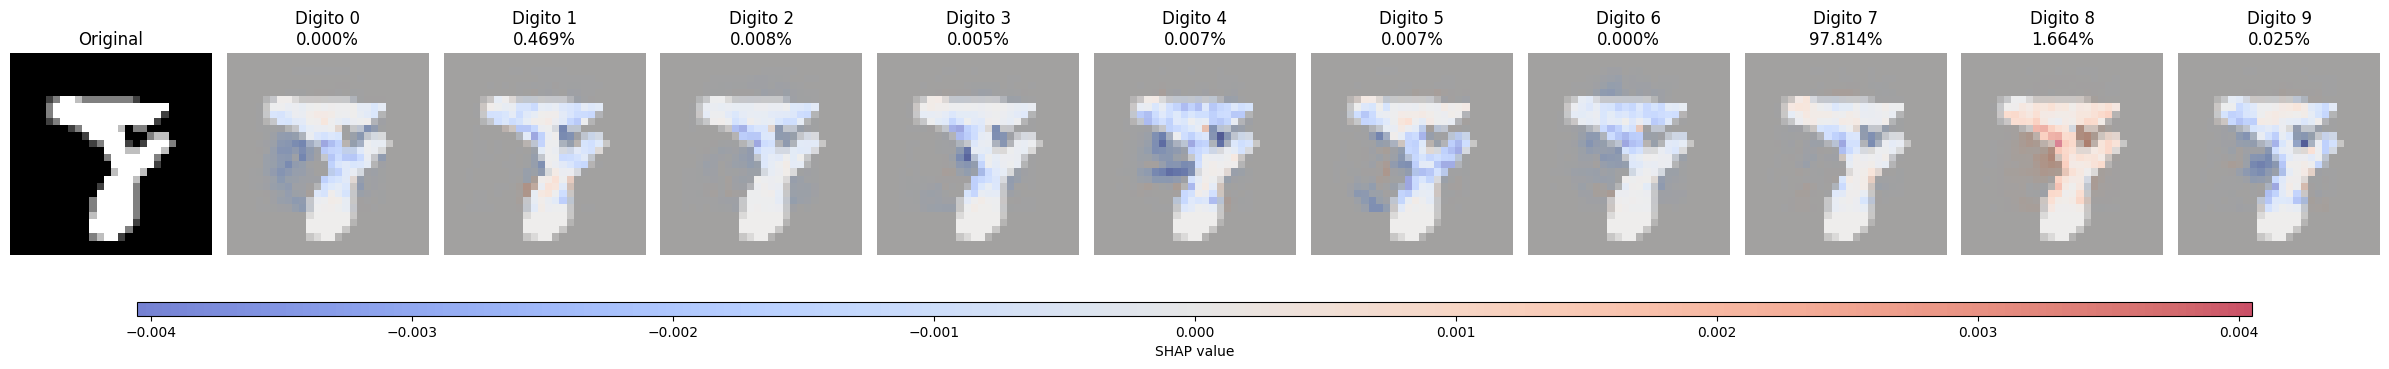

Predicted label: 7
True label: 2


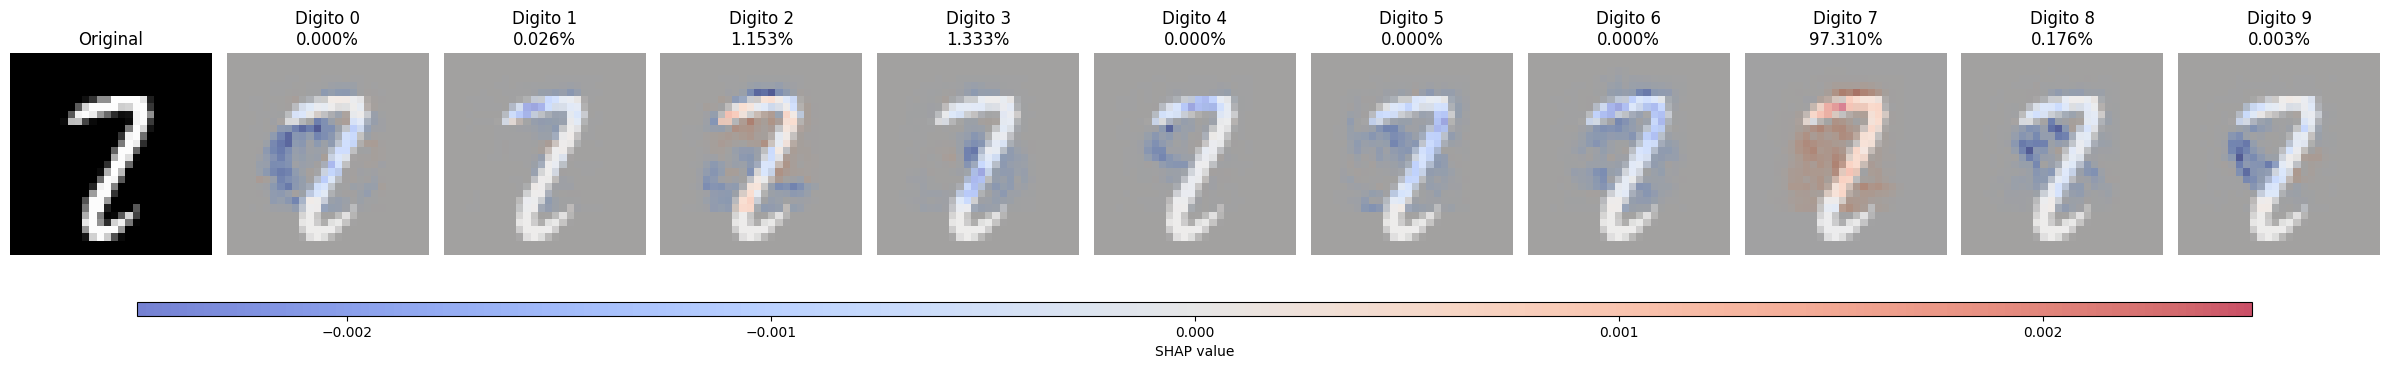

Predicted label: 2
True label: 7


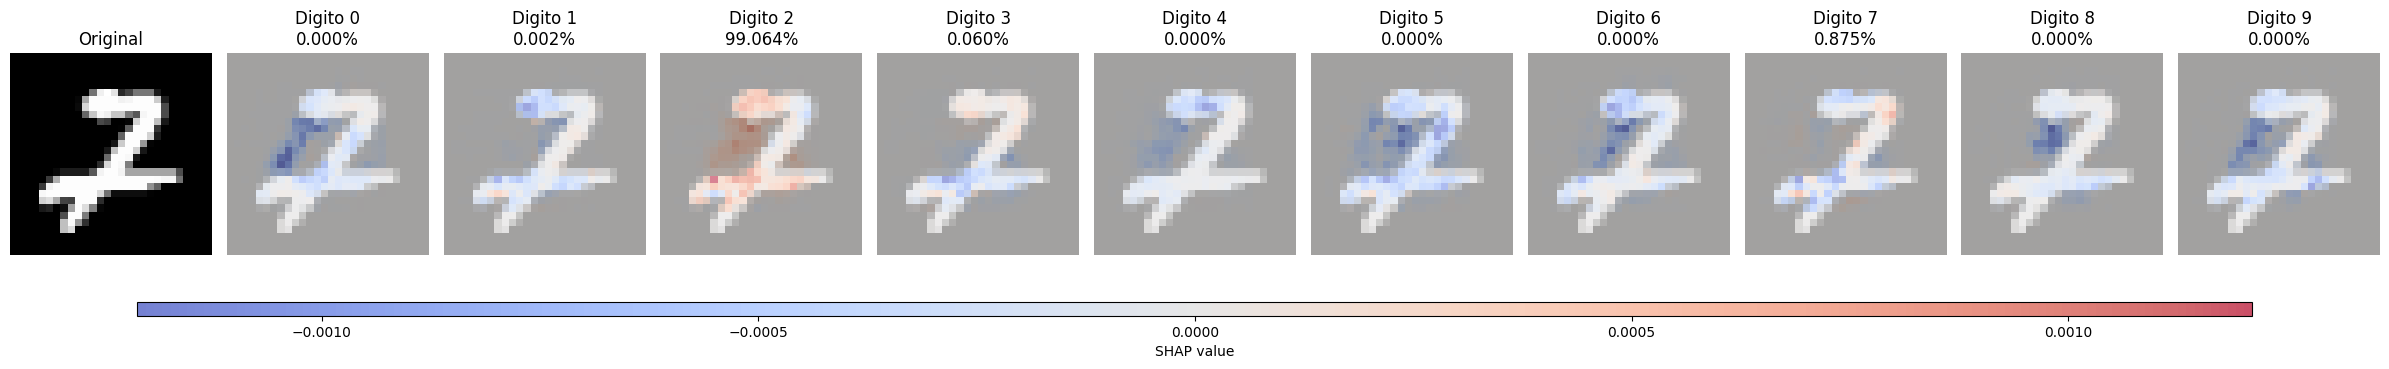

Predicted label: 8
True label: 3


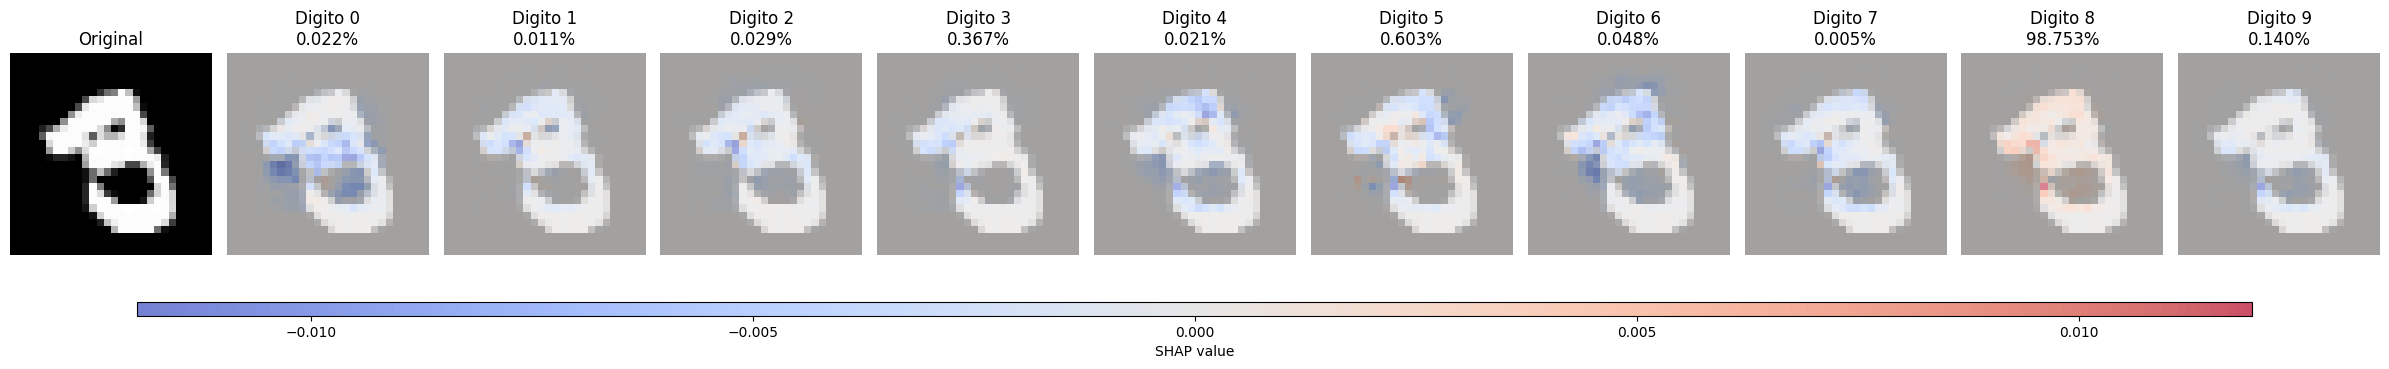

Predicted label: 6
True label: 5


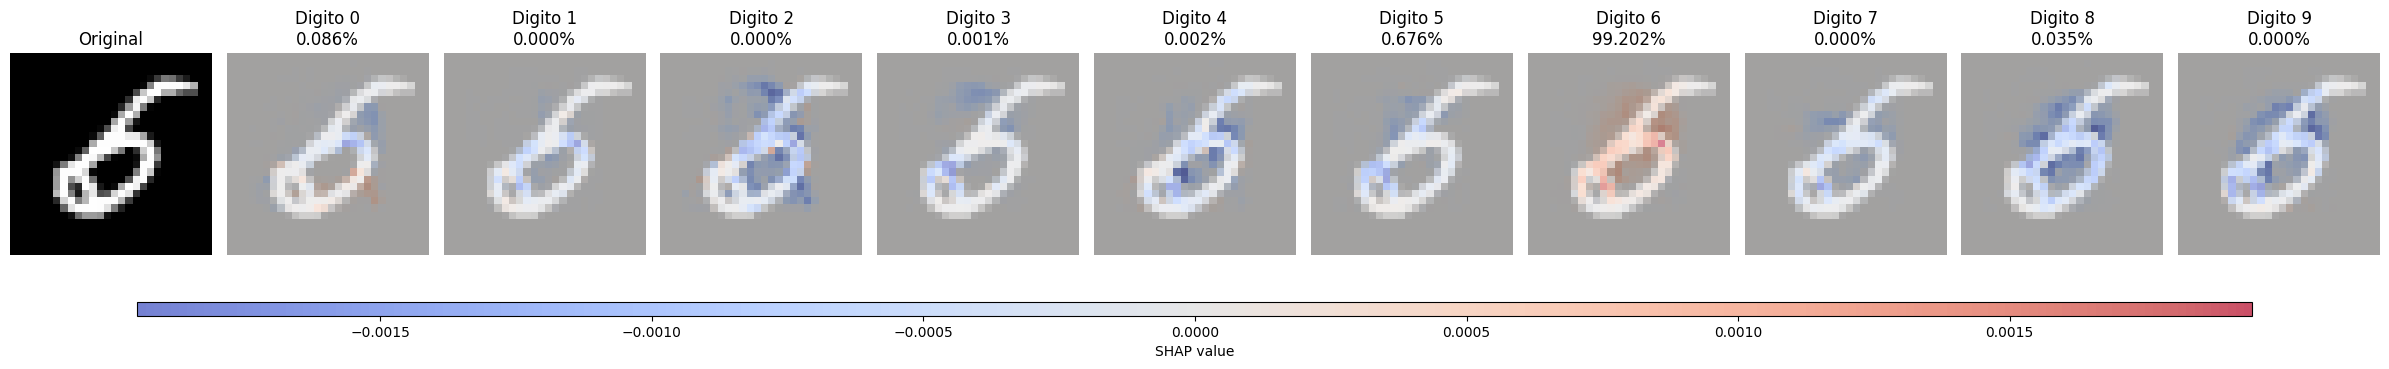

Predicted label: 2
True label: 7


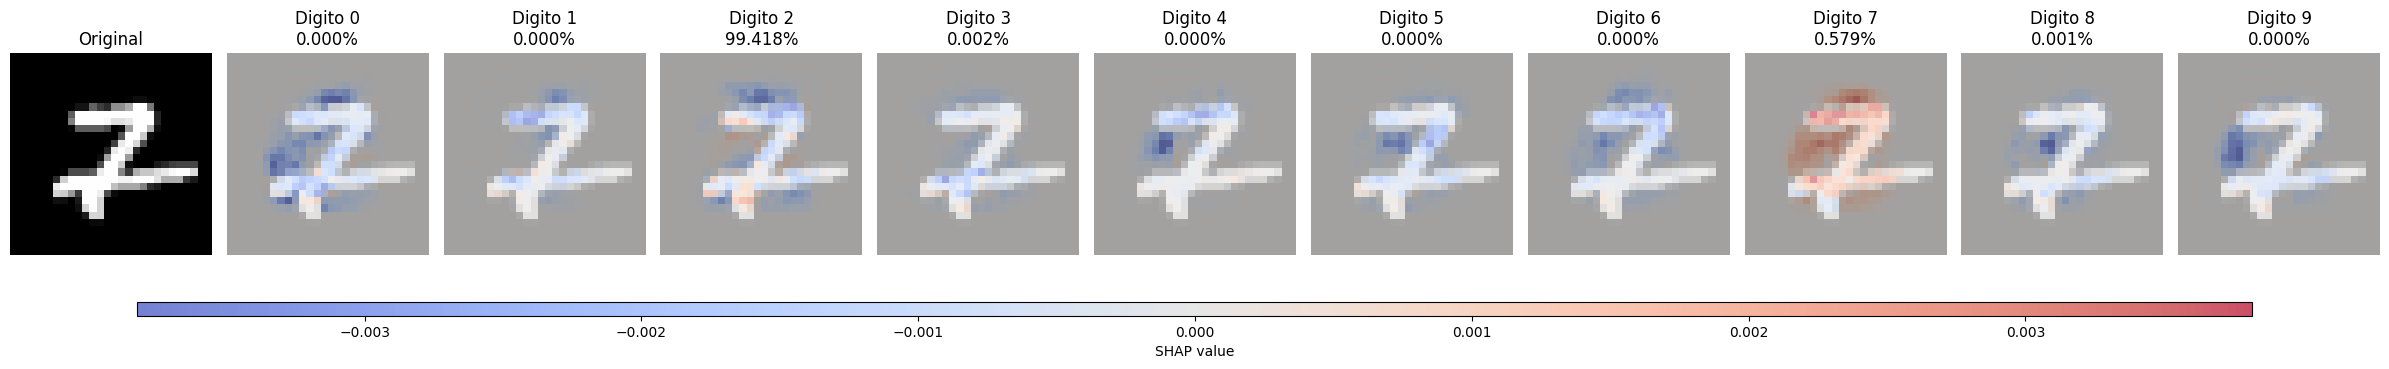

Predicted label: 4
True label: 6


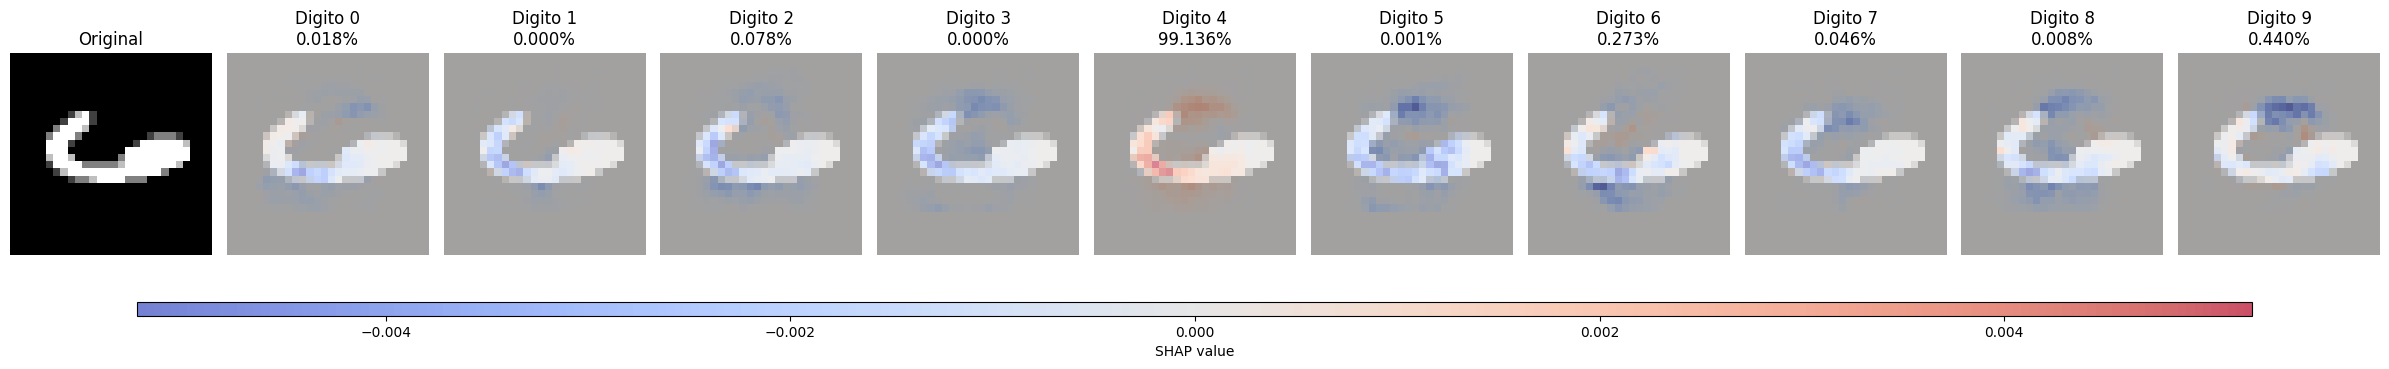

Predicted label: 5
True label: 6


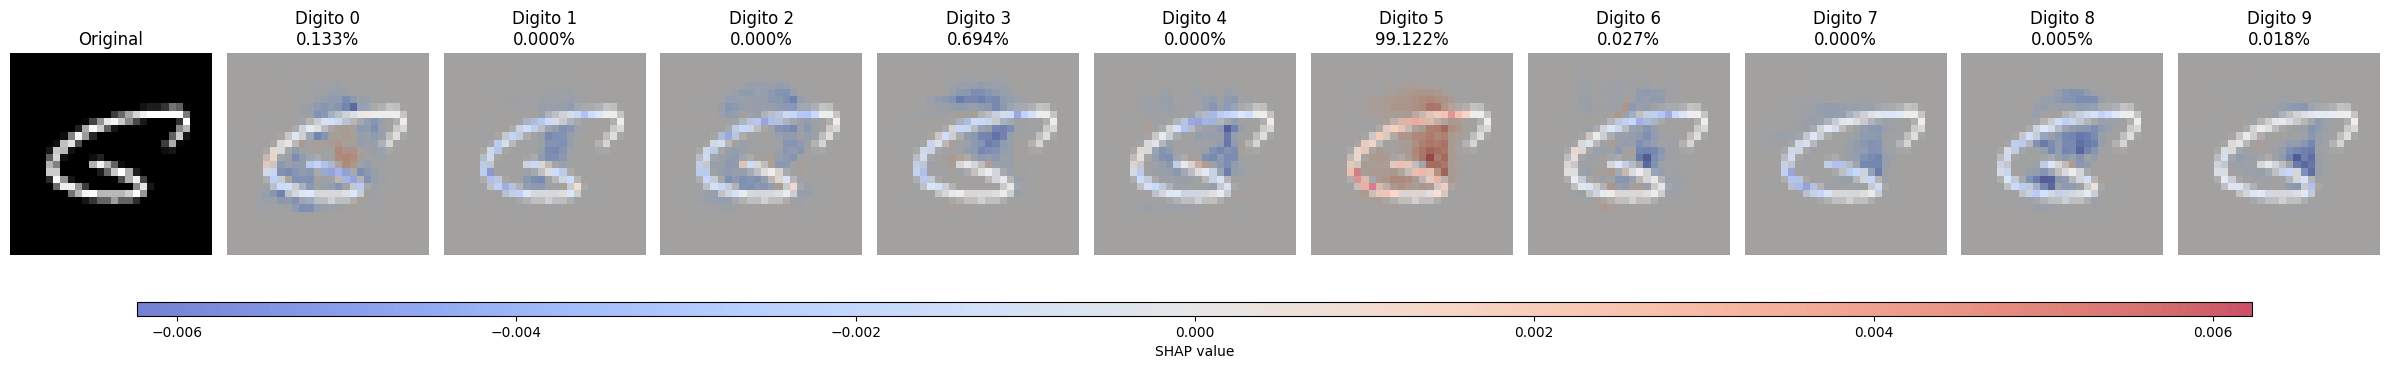

Predicted label: 0
True label: 8


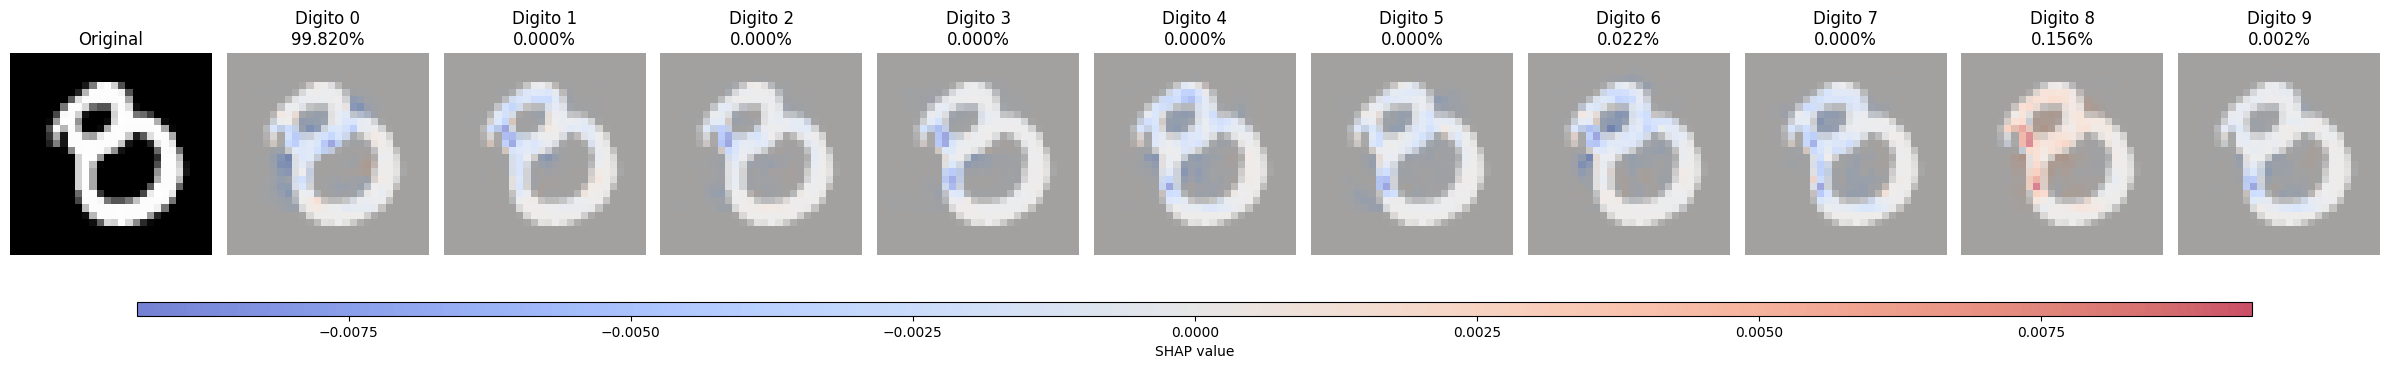

Predicted label: 1
True label: 6


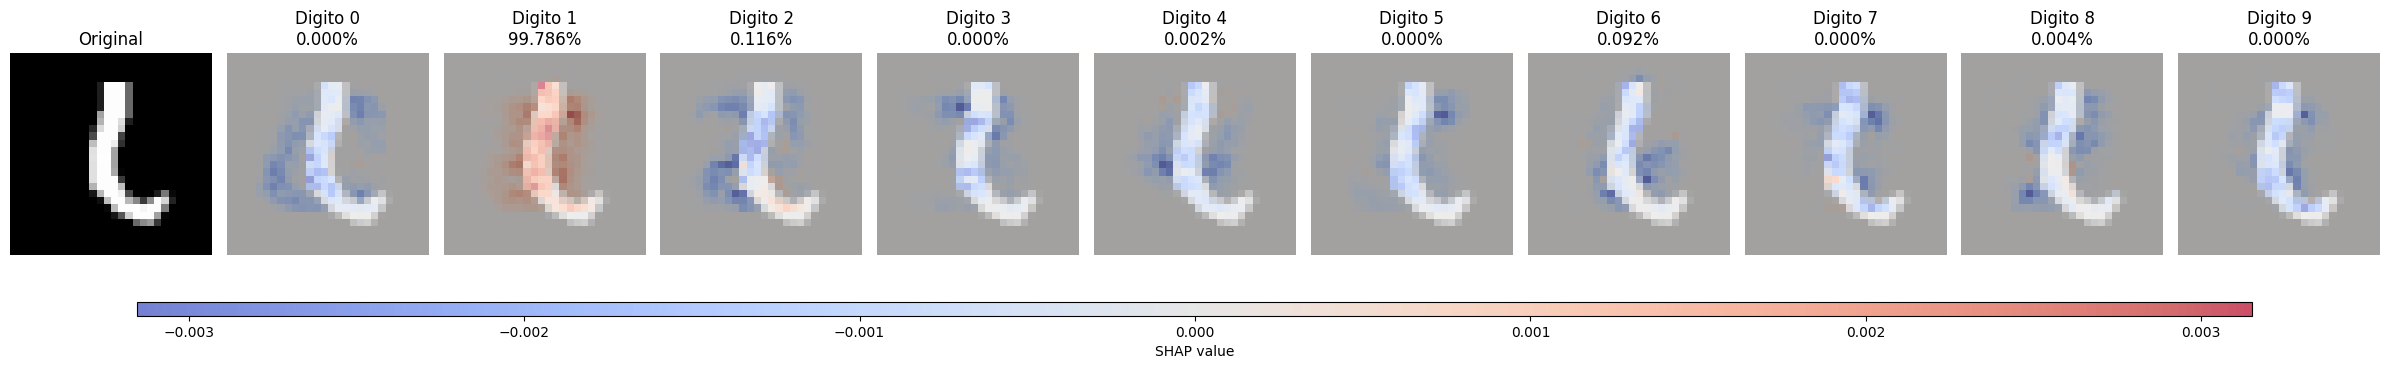

In [61]:
# Mostrar los errores más importantes
display_errors(model_3, most_important_errors, test_errors, test_labels_classes_errors, test_true_errors)

In [66]:
most_important_errors

array([65, 14, 55, 51])

In [69]:
models = []
models.append(model_1)
models.append(model_2)
models.append(model_3)

In [93]:
# Función para predecir y analizar errores
def analyze_model(model, x_test, y_test, bien = True):
    # Predecir en el conjunto de prueba
    preds = model.predict(x_test)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    # Identificar los errores de predicción
    if bien:
      errors = (pred_labels == true_labels)
    else:
      errors = (pred_labels != true_labels)

    test_labels_classes_errors = pred_labels[errors]
    test_labels_errors = preds[errors]
    test_true_errors = true_labels[errors]
    test_errors = x_test[errors]

    # Calcular las probabilidades y deltas
    test_labels_errors_prob = np.max(test_labels_errors, axis=1)
    true_prob_errors = np.diagonal(np.take(test_labels_errors, test_true_errors, axis=1))
    delta_pred_true_errors = test_labels_errors_prob - true_prob_errors
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    most_important_errors = sorted_delta_errors[-4:]

    return most_important_errors, test_errors, test_labels_classes_errors, test_true_errors, test_labels_errors


In [71]:
# Función para mostrar los errores más importantes
def display_errors(model, most_important_errors, test_errors, test_labels_classes_errors, test_true_errors, test_labels_errors):
    background = x_train_mnist[np.random.choice(x_train_mnist.shape[0], 100, replace=False)].reshape(-1, 28, 28, 1)
    explainer = shap.DeepExplainer(model, background)

    for idx in most_important_errors:
        i = idx  # Índice del error más importante
        # Calcular los valores SHAP
        shap_values = explainer.shap_values(test_errors[i].reshape(1, 28, 28, 1))

        # Etiquetas y probabilidades
        probabilities = test_labels_errors[i]
        index_names = np.array([f"{x}\n{probabilities[x]:.3%}" for x in range(10)]).reshape(1, 10)

        # Mostrar los resultados
        print(f"Predicted label: {test_labels_classes_errors[i]}\nTrue label: {test_true_errors[i]}")

        fig, axes = plt.subplots(1, 11, figsize=(24, 5))  # Añadir un subplot adicional para la imagen original

        # Mostrar la imagen original
        axes[0].imshow(test_errors[i].reshape(28, 28), cmap='gray')
        axes[0].set_title("Original")
        axes[0].axis('off')

        # Mostrar las imágenes con valores SHAP superpuestos
        for digit in range(10):
            # Limitar los valores SHAP para mejorar la visualización
            shap_img = shap_values[0][..., digit].reshape(28, 28)
            max_val = np.abs(shap_img).max()
            img = axes[digit + 1].imshow(shap_img, cmap='coolwarm', vmin=-max_val, vmax=max_val, alpha=0.7)
            axes[digit + 1].imshow(test_errors[i].reshape(28, 28), cmap='gray', alpha=0.3)
            axes[digit + 1].set_title(f"Digito {digit}\n{probabilities[digit]:.3%}")
            axes[digit + 1].axis('off')

        plt.tight_layout()

        # Añadir barra de colores completa
        cbar = fig.colorbar(img, ax=axes, orientation='horizontal', fraction=0.03, pad=0.1, aspect=150)
        cbar.set_label('SHAP value')

        plt.show()


In [76]:
errores[:2]

array([65, 14])

313/313 [==============================] - 4s 12ms/step
modelo [65 14]


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Predicted label: 0
True label: 8


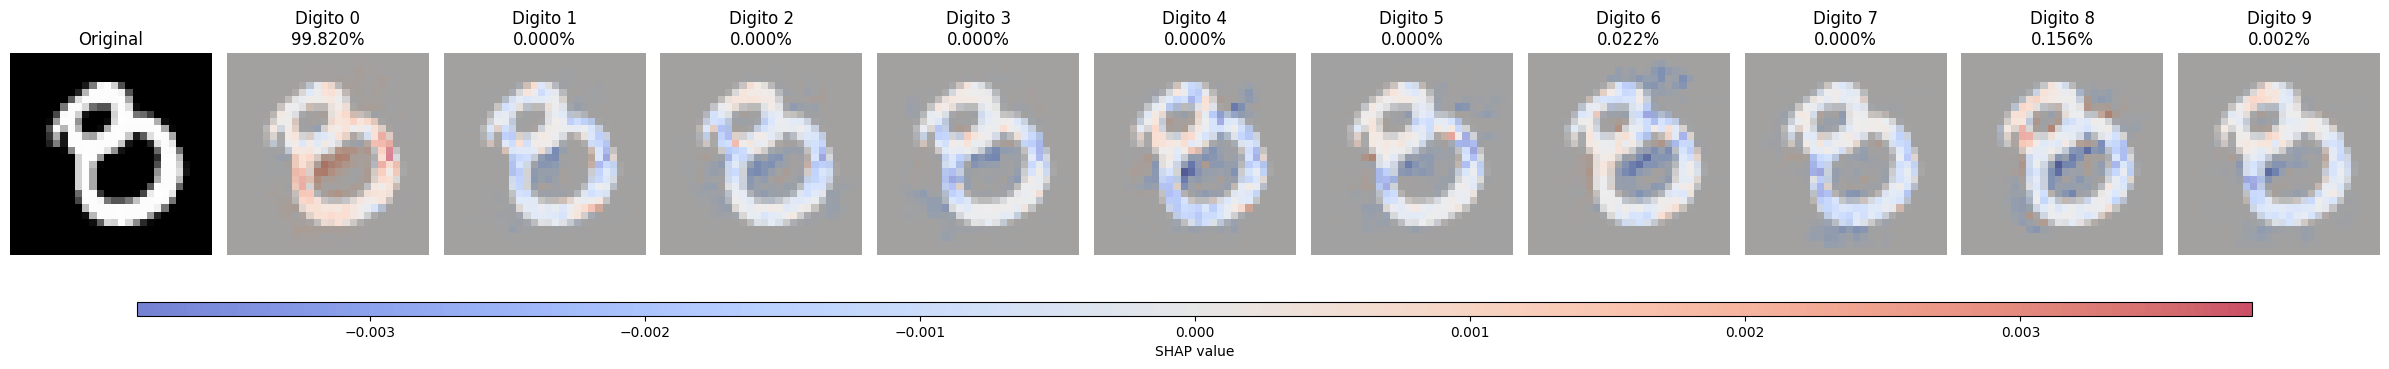

313/313 [==============================] - 5s 15ms/step
modelo [83 13]
Predicted label: 0
True label: 8


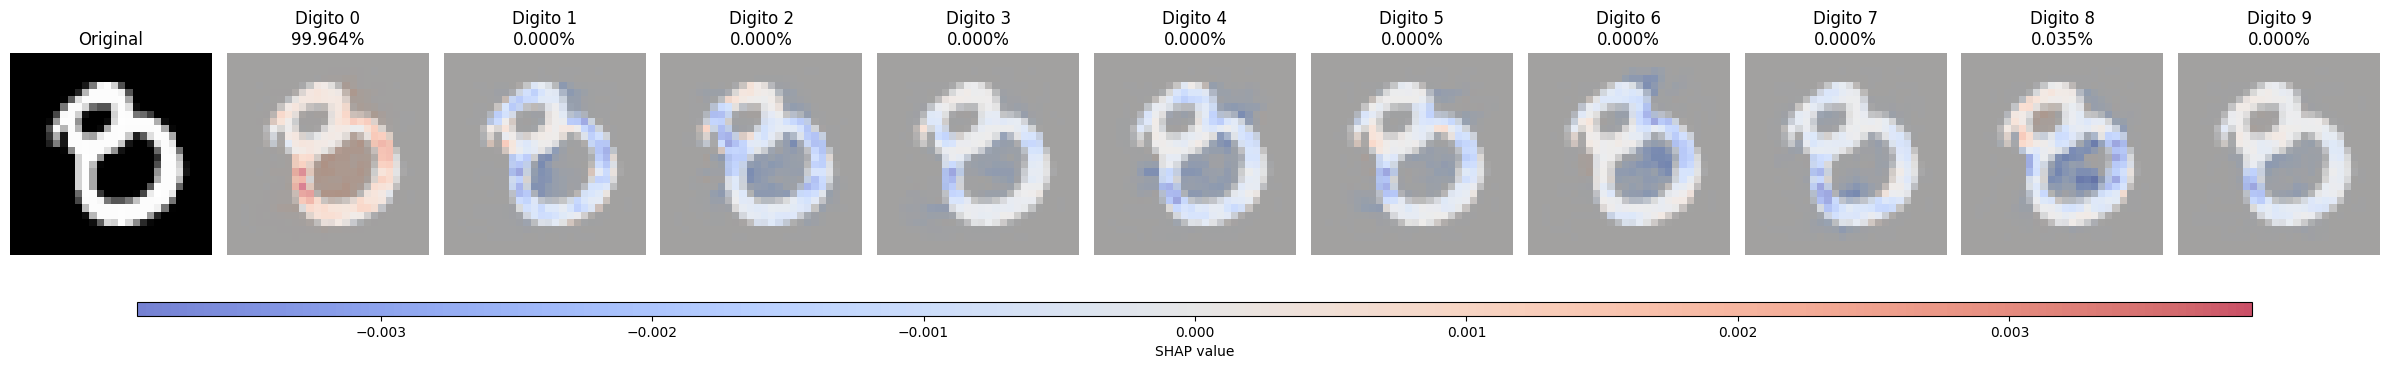

313/313 [==============================] - 4s 13ms/step
modelo [ 53 103]
Predicted label: 7
True label: 2


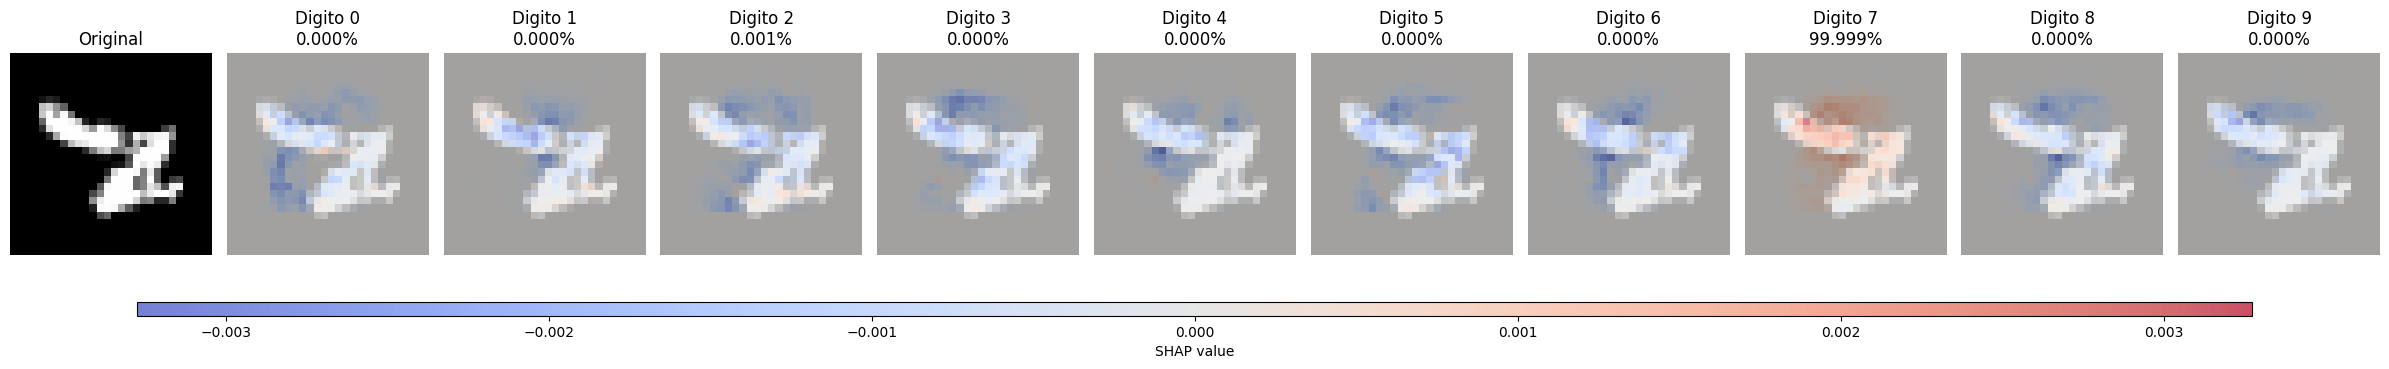

In [94]:
# Análisis y visualización para cada modelo mal clasificado
for model in models:
    most_important_errors, test_errors, test_labels_classes_errors, test_true_errors, test_labels_errors = analyze_model(model, x_test_mnist, y_test_mnist, False)
    print("modelo", most_important_errors[:2])
    display_errors(model, most_important_errors[2:3], test_errors, test_labels_classes_errors, test_true_errors, test_labels_errors)

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


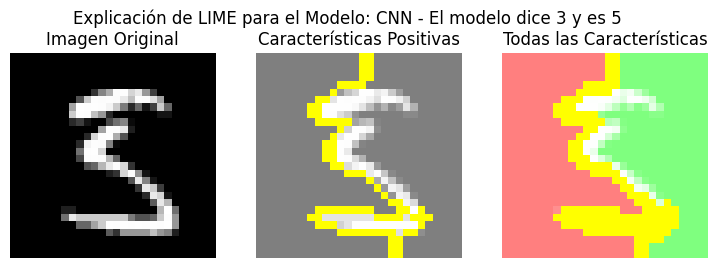

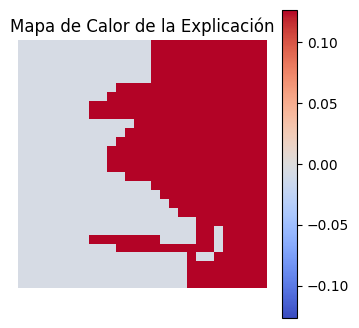

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


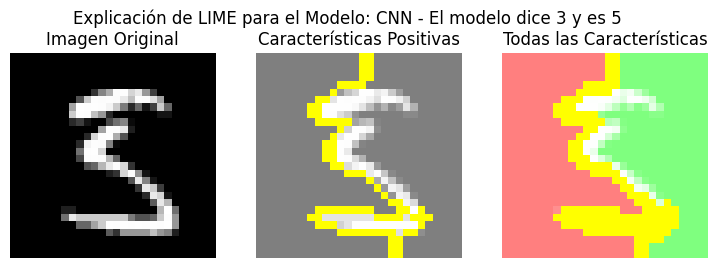

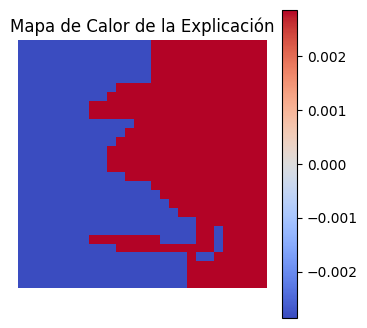

1/1 [==============================] - 0s 52ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


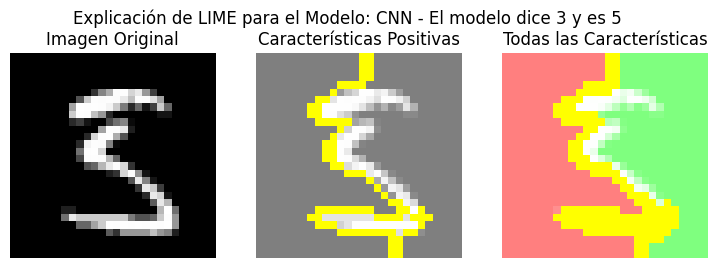

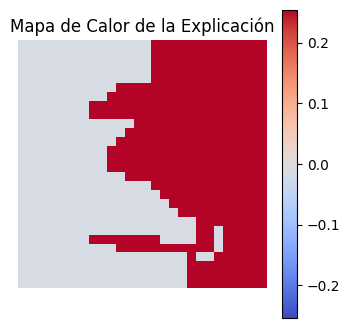

In [91]:
for model in models:
  i = most_important_errors[0]
  image = test_errors[i]
  val_real = test_true_errors[i]
# Explicar la instancia
  explain_instance_with_lime(image, model.predict, "CNN", val_real, model_type='cnn')

## Bien clasificados

313/313 [==============================] - 2s 6ms/step
modelo [3295 3296]


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Predicted label: 7
True label: 7


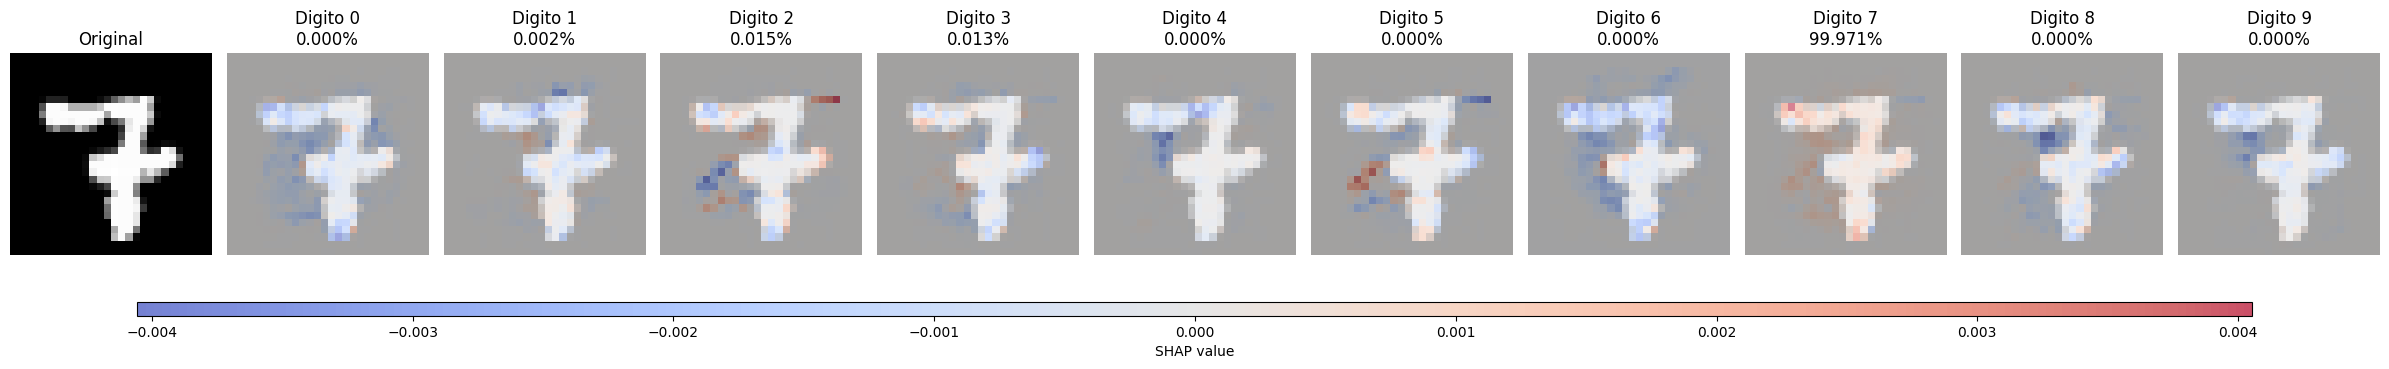

313/313 [==============================] - 5s 15ms/step
modelo [3307 3308]
Predicted label: 0
True label: 0


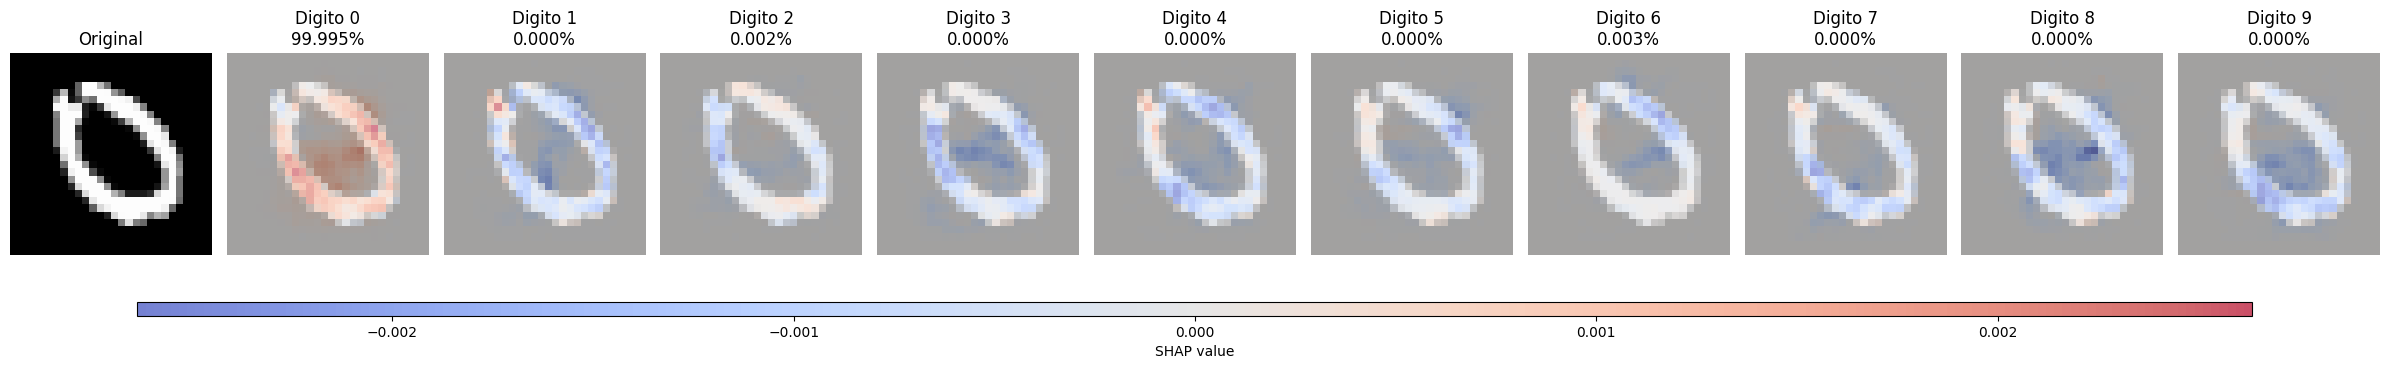

313/313 [==============================] - 5s 15ms/step
modelo [3294 3295]
Predicted label: 6
True label: 6


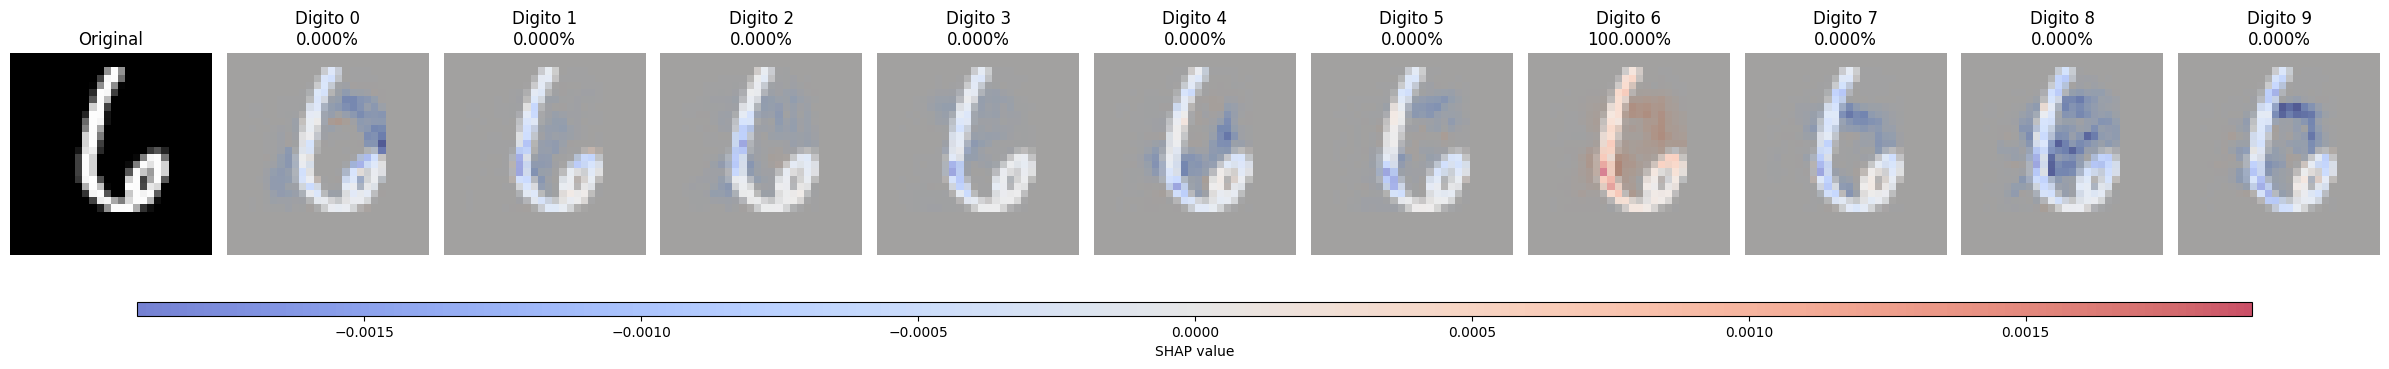

In [95]:
# Análisis y visualización para cada modelo mal clasificado
for model in models:
    most_important_errors, test_errors, test_labels_classes_errors, test_true_errors, test_labels_errors = analyze_model(model, x_test_mnist, y_test_mnist, True)
    print("modelo", most_important_errors[:2])
    display_errors(model, most_important_errors[2:3], test_errors, test_labels_classes_errors, test_true_errors, test_labels_errors)

1/1 [==============================] - 0s 77ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


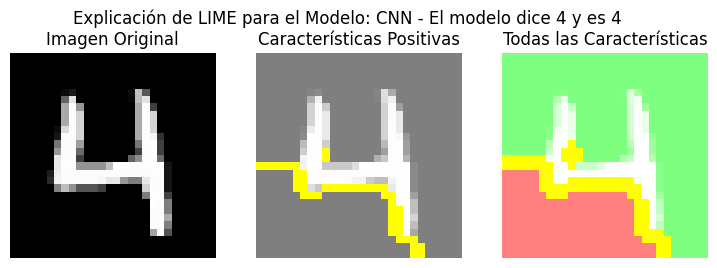

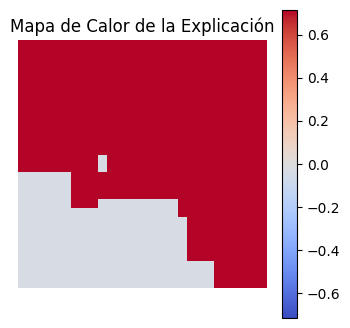

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


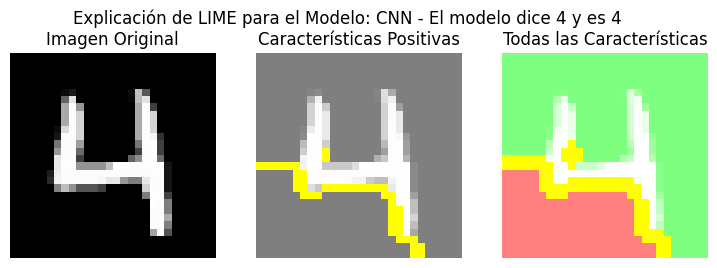

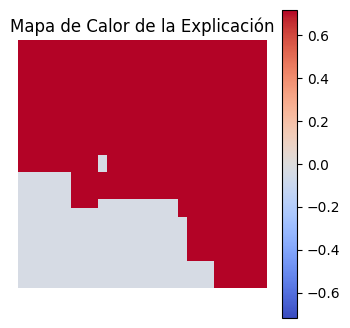

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


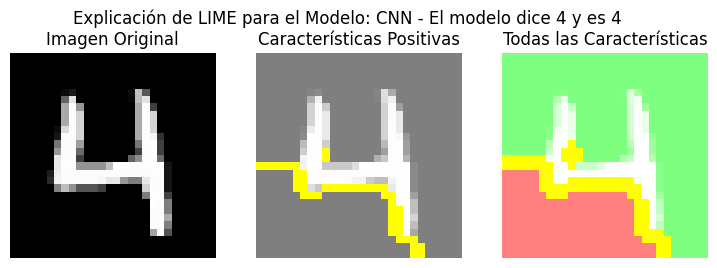

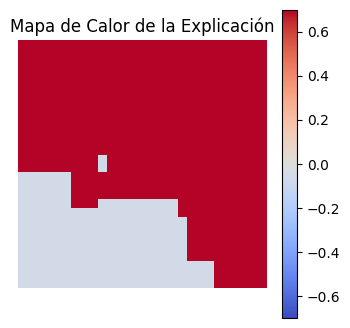

In [97]:
for model in models:
  i = most_important_errors[1]
  image = test_errors[i]
  val_real = test_true_errors[i]
# Explicar la instancia
  explain_instance_with_lime(image, model.predict, "CNN", val_real, model_type='cnn')

In [108]:
for idx, model in enumerate(models, 1):
    model.save(f'model_{idx}.keras')

# Otras cosas

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

<ipython-input-105-2bb752de49da>:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


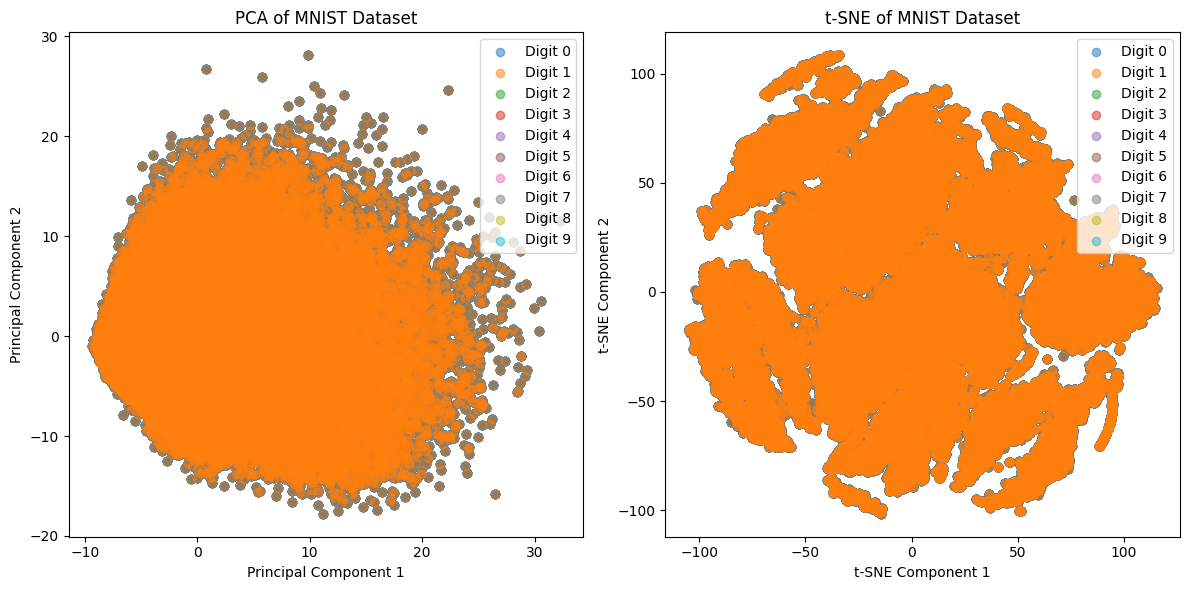

In [105]:
# Aplanar las imágenes
x_train_flat = x_train_mnist.reshape(x_train_mnist.shape[0], -1)
x_test_flat = x_test_mnist.reshape(x_test_mnist.shape[0], -1)

# Escalar los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Realizar PCA
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# Realizar t-SNE
tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)
x_test_tsne = tsne.fit_transform(x_test_scaled)


<ipython-input-107-2ff487c4b284>:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


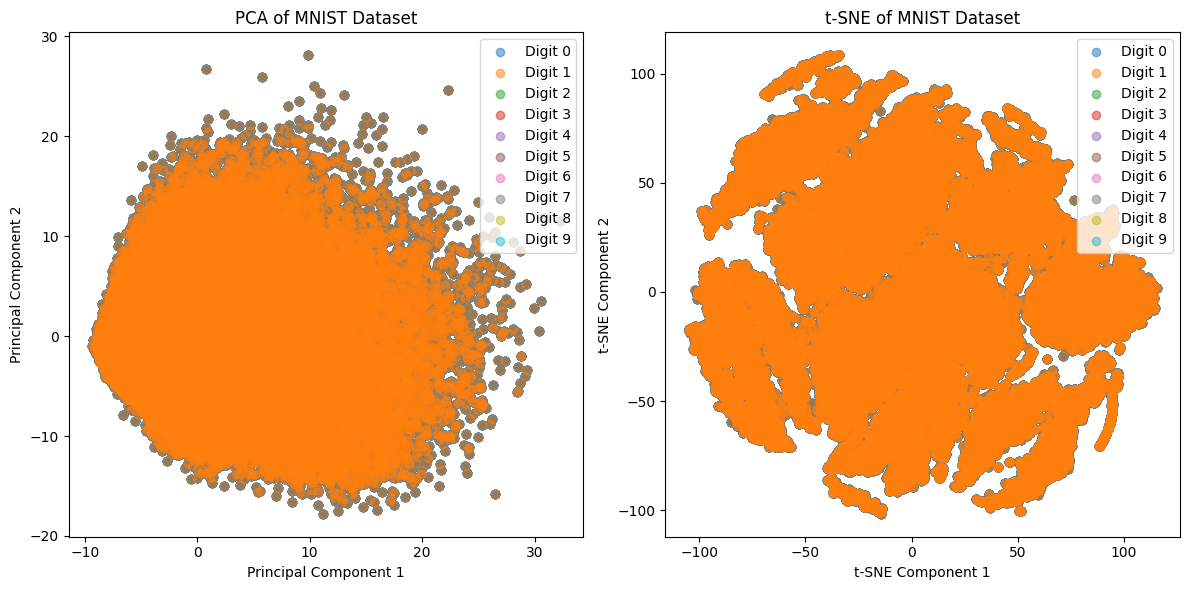

In [107]:

# Visualizar los clusters con PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(10):
    indices = np.where(y_train_mnist == i)
    plt.scatter(x_train_pca[indices, 0], x_train_pca[indices, 1], label=f"Digit {i}", alpha=0.5)
plt.title('PCA of MNIST Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Visualizar los clusters con t-SNE
plt.subplot(1, 2, 2)
for i in range(10):
    indices = np.where(y_train_mnist == i)
    plt.scatter(x_train_tsne[indices, 0], x_train_tsne[indices, 1], label=f"Digit {i}", alpha=0.5)
plt.title('t-SNE of MNIST Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

plt.tight_layout()
plt.show()